In [1]:
import sys, os
import numpy as np
import time, h5py
codepath = '/user_data/mmhender/imStat/code'
sys.path.append(codepath)
from utils import default_paths, nsd_utils, numpy_utils, stats_utils, prf_utils
from plotting import plot_utils
from model_fitting import initialize_fitting 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import argparse
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import scipy.stats


In [7]:
# load LDA results
subject = 1
which_prf_grid = 5
# Params for the spatial aspect of the model (possible pRFs)
models = initialize_fitting.get_prf_models(which_grid=which_prf_grid)    
n_prfs = models.shape[0]

save_name_groups = os.path.join(default_paths.stim_labels_root,'All_concat_labelgroupnames.npy')
groups = np.load(save_name_groups, allow_pickle=True).item()
discrim_type_list = groups['discrim_type_list']
n_discrim_types = len(discrim_type_list)

feature_type_list = ['gabor_solo','pyramid_texture_ll','pyramid_texture_hl_pca','sketch_tokens',\
                    'alexnet','clip']
feature_folders = [default_paths.gabor_texture_feat_path,default_paths.pyramid_texture_feat_path,\
                  default_paths.pyramid_texture_feat_path, default_paths.sketch_token_feat_path, \
                  default_paths.alexnet_feat_path, default_paths.clip_feat_path]
 
trn_acc = np.zeros((len(feature_type_list), n_discrim_types, n_prfs))
trn_dprime= np.zeros((len(feature_type_list), n_discrim_types, n_prfs))
val_acc = np.zeros((len(feature_type_list), n_discrim_types, n_prfs))
val_dprime = np.zeros((len(feature_type_list), n_discrim_types, n_prfs))
nsamp_trn = np.zeros((len(feature_type_list), n_discrim_types, n_prfs, 2))
nsamp_val = np.zeros((len(feature_type_list), n_discrim_types, n_prfs, 2))

for ff in range(len(feature_type_list)):
    feature_type = feature_type_list[ff]
# for ff, feature_type in enumerate(feature_type_list):

    path_to_load = os.path.join(feature_folders[ff], 'LDA')

    fn2save = os.path.join(path_to_load, \
                       'S%d_%s_LDA_all_grid%d.npy'%(subject, feature_type,which_prf_grid))
#     fn2save = os.path.join(path_to_load, \
#                        'All_%s_LDA_all_grid%d.npy'%(feature_type,which_prf_grid))

    print('loading from %s'%fn2save)
    lda_result = np.load(fn2save,allow_pickle=True).item()
    trn_acc[ff,:,:] = np.array(lda_result['trn_acc']).T
    trn_dprime[ff,:,:] = np.array(lda_result['trn_dprime']).T
    val_acc[ff,:,:] = np.array(lda_result['val_acc']).T
    val_dprime[ff,:,:] = np.array(lda_result['val_dprime']).T

    if ff==0:
        nsamp_trn[ff,:,:,:] = np.moveaxis(lda_result['n_samp_trn_each_prf'], [0,1,2],[1,0,2])
        nsamp_val[ff,:,:,:] = np.moveaxis(lda_result['n_samp_val_each_prf'], [0,1,2],[1,0,2])


# exclude any pRFs for which there were fewer than 10 trials

min_thresh = 10
inds_exclude = np.any(nsamp_val[0,:,:,:]<min_thresh, axis=2) \
                | np.any(nsamp_trn[0,:,:,:]<min_thresh, axis=2)
inds_exclude.shape

trn_acc[:,inds_exclude] = np.nan
trn_dprime[:,inds_exclude] = np.nan
val_acc[:,inds_exclude] = np.nan
val_dprime[:,inds_exclude] = np.nan


number of pRFs: 1456
most extreme RF positions:
[2.7755576e-17 0.0000000e+00 2.0000000e-02]
[ 0.7698996  -0.31890285  1.        ]
loading from /user_data/mmhender/features/gabor_texture/LDA/S1_gabor_solo_LDA_all_grid5.npy
loading from /user_data/mmhender/features/pyramid_texture/LDA/S1_pyramid_texture_ll_LDA_all_grid5.npy
loading from /user_data/mmhender/features/pyramid_texture/LDA/S1_pyramid_texture_hl_pca_LDA_all_grid5.npy
loading from /user_data/mmhender/features/sketch_tokens/LDA/S1_sketch_tokens_LDA_all_grid5.npy
loading from /user_data/mmhender/features/alexnet/LDA/S1_alexnet_LDA_all_grid5.npy
loading from /user_data/mmhender/features/CLIP/LDA/S1_clip_LDA_all_grid5.npy


In [8]:
# make some groups (averaging over all superord or basic level discrims)

inds2group = [[0], [1], [2], np.arange(3,15), np.arange(26,42), np.arange(15,26), np.arange(42,54)]
group_names = [discrim_type_list[ii] for ii in [0,1,2]] + \
                ['things-superord','stuff-superord' ,'things-basic', 'stuff-basic']

trn_acc_grouped = np.zeros((len(feature_type_list), len(inds2group), n_prfs))
val_acc_grouped = np.zeros((len(feature_type_list), len(inds2group), n_prfs))
trn_dprime_grouped = np.zeros((len(feature_type_list), len(inds2group), n_prfs))
val_dprime_grouped = np.zeros((len(feature_type_list), len(inds2group), n_prfs))
for gg, inds in enumerate(inds2group):
    trn_acc_grouped[:,gg,:] = np.nanmean(trn_acc[:,inds,:], axis=1)
    val_acc_grouped[:,gg,:] = np.nanmean(val_acc[:,inds,:], axis=1)
    trn_dprime_grouped[:,gg,:] = np.nanmean(trn_dprime[:,inds,:], axis=1)
    val_dprime_grouped[:,gg,:] = np.nanmean(val_dprime[:,inds,:], axis=1)
    print(group_names[gg])
    print(np.array(discrim_type_list)[inds])

indoor_outdoor
['indoor_outdoor']
natural_humanmade
['natural_humanmade']
animacy
['animacy']
things-superord
['accessory' 'animal' 'appliance' 'electronic' 'food' 'furniture' 'indoor'
 'kitchen' 'outdoor' 'person' 'sports' 'vehicle']
stuff-superord
['building' 'ceiling' 'floor' 'food-stuff' 'furniture-stuff' 'ground'
 'other' 'plant' 'raw-material' 'sky' 'solid' 'structural' 'textile'
 'wall' 'water' 'window']
things-basic
['within_accessory' 'within_animal' 'within_appliance' 'within_electronic'
 'within_food' 'within_furniture' 'within_indoor' 'within_kitchen'
 'within_outdoor' 'within_sports' 'within_vehicle']
stuff-basic
['within_building' 'within_floor' 'within_food-stuff'
 'within_furniture-stuff' 'within_ground' 'within_plant'
 'within_raw-material' 'within_solid' 'within_structural' 'within_textile'
 'within_wall' 'within_water']


/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/mmhender/myenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/mmhender/myenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


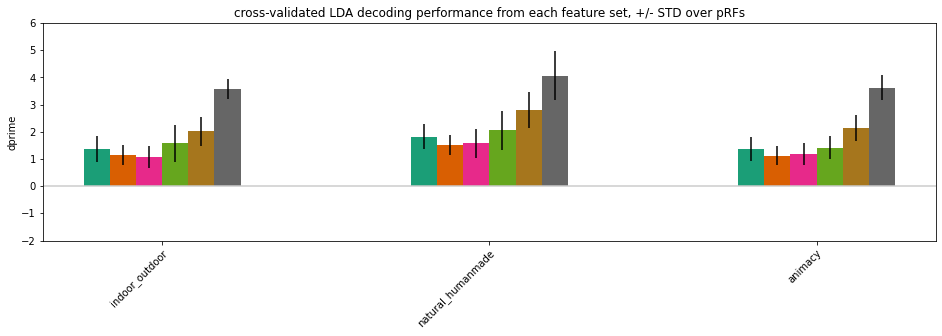

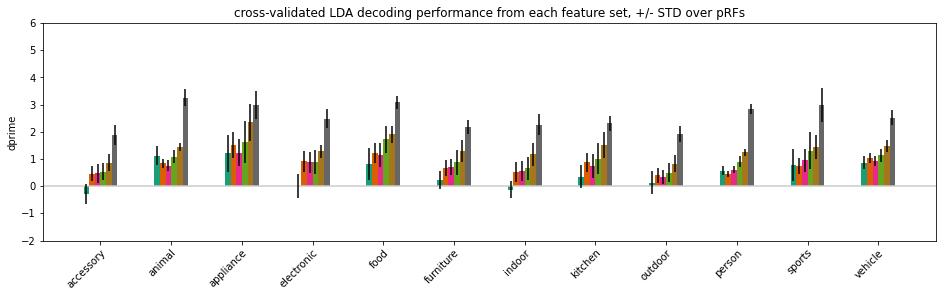

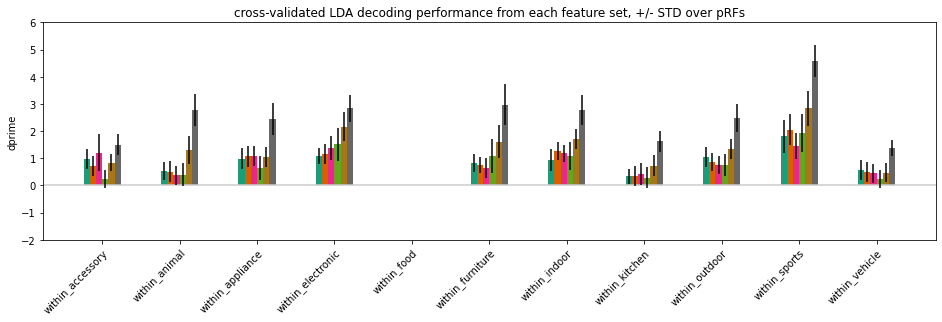

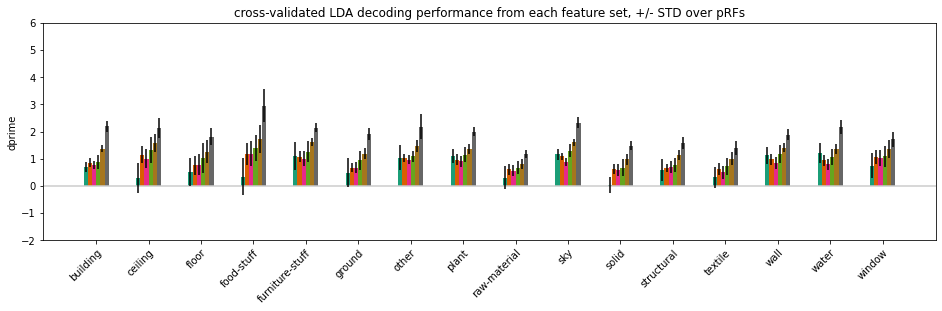

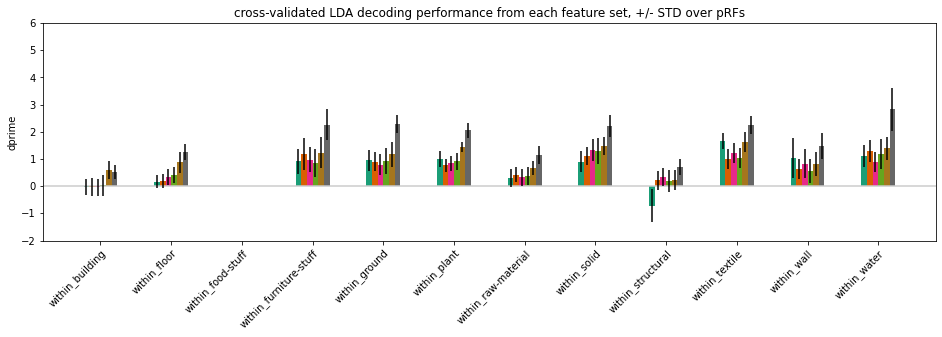

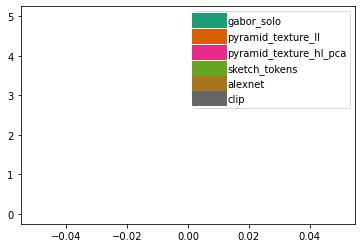

In [22]:
inds_list = [np.arange(0,3), np.arange(3,15), np.arange(15,26), np.arange(26,42), np.arange(42,54)]

feature_colors = cm.Dark2(np.linspace(0,1,len(feature_type_list)))

for ii, inds in enumerate(inds_list):
    
    mean_vals = np.nanmean(val_dprime[:,inds,:], axis=2).T;
    std_vals = np.nanstd(val_dprime[:,inds,:], axis=2).T;
    
    title = 'cross-validated LDA decoding performance from each feature set, +/- STD over pRFs'

    if ii==len(inds_list)-1:
        legend_separate=True
    else:
        legend_separate=False
        
    plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=std_vals, colors=feature_colors, space=0.3, \
                    xticklabels=np.array(discrim_type_list)[inds], ylabel='dprime', \
                    ylim=[-2,6], title=title, horizontal_line_pos=0,\
                    legend_labels=feature_type_list, \
                    legend_overlaid=False, legend_separate=legend_separate, \
                    fig_size=(16,4))

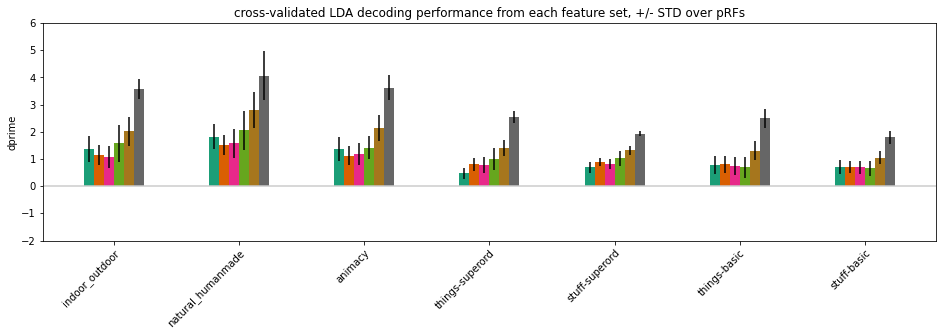

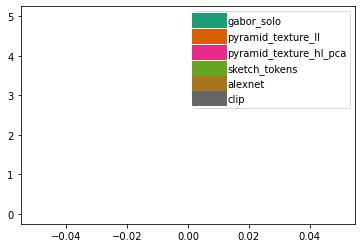

In [10]:
# Average performance within each level of categorization

feature_colors = cm.Dark2(np.linspace(0,1,len(feature_type_list)))

mean_vals = np.nanmean(val_dprime_grouped, axis=2).T;
std_vals = np.nanstd(val_dprime_grouped, axis=2).T;

title = 'cross-validated LDA decoding performance from each feature set, +/- STD over pRFs'

legend_separate=True
plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=std_vals, colors=feature_colors, space=0.3, \
                xticklabels=group_names, ylabel='dprime', \
                ylim=[-2,6], title=title, horizontal_line_pos=0,\
                legend_labels=feature_type_list, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

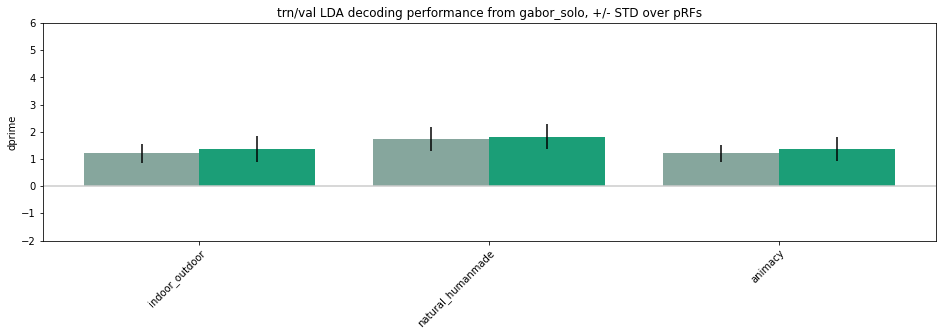

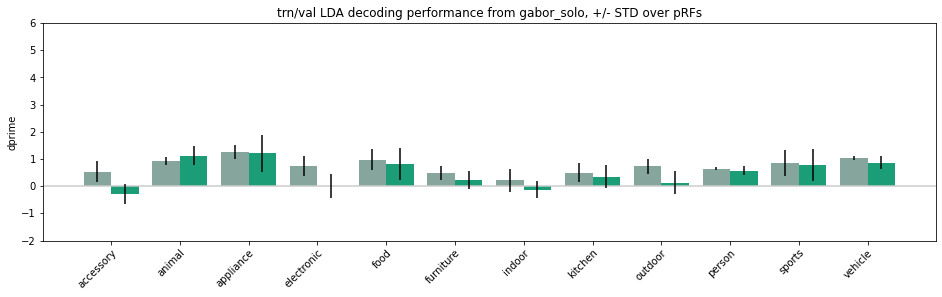

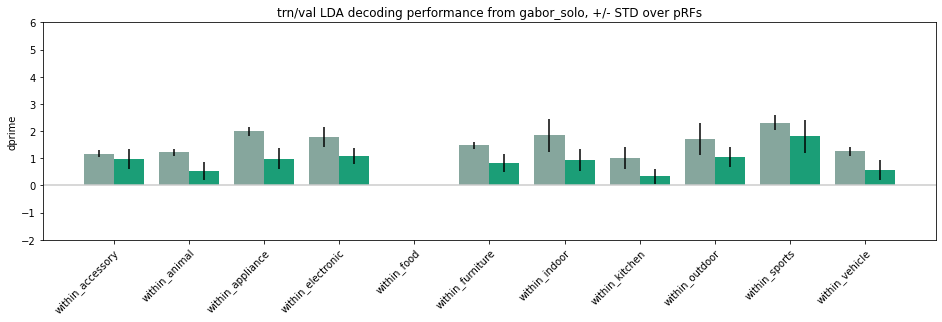

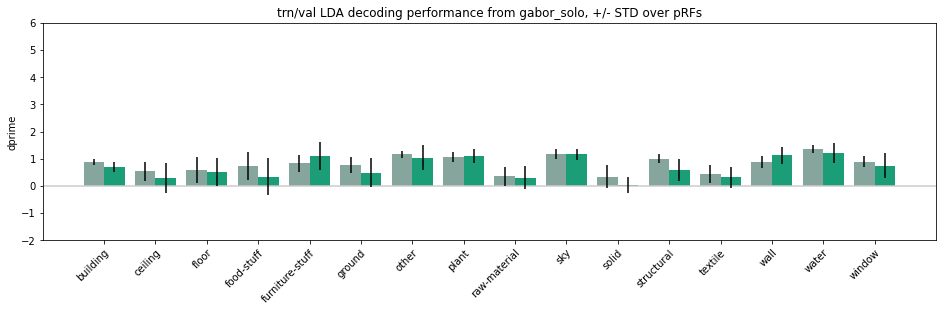

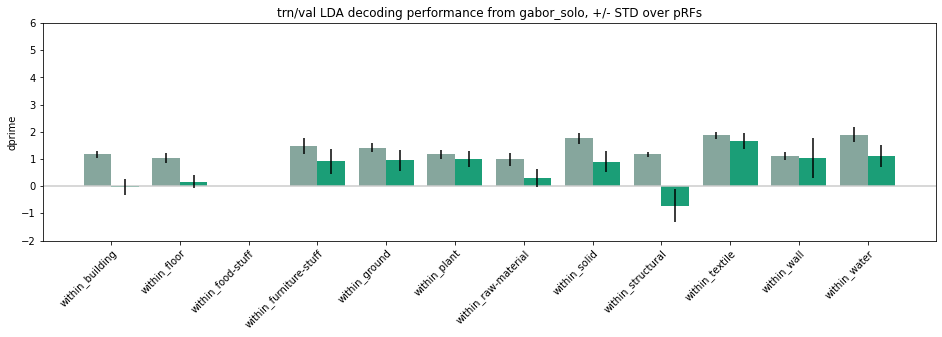

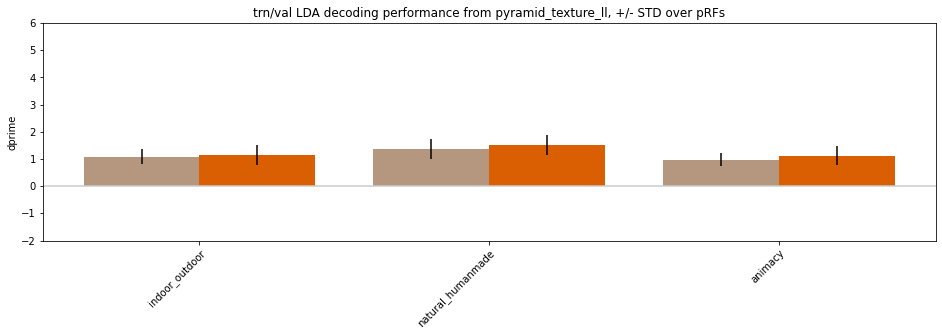

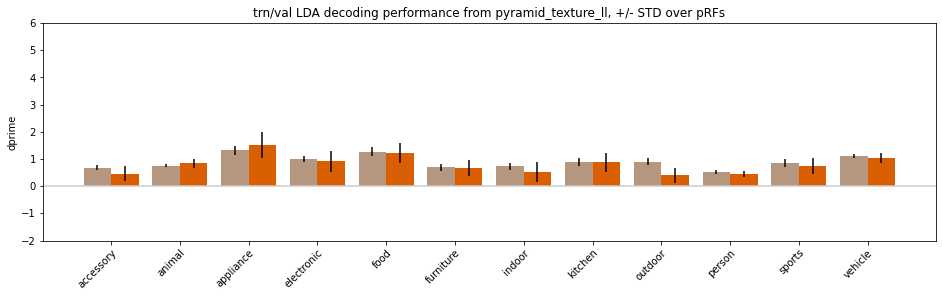

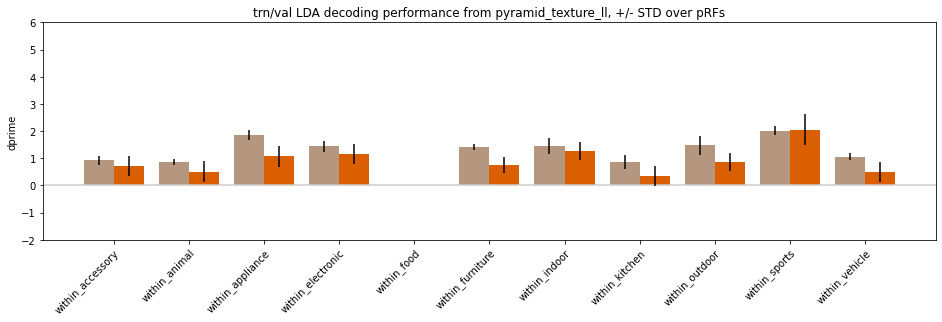

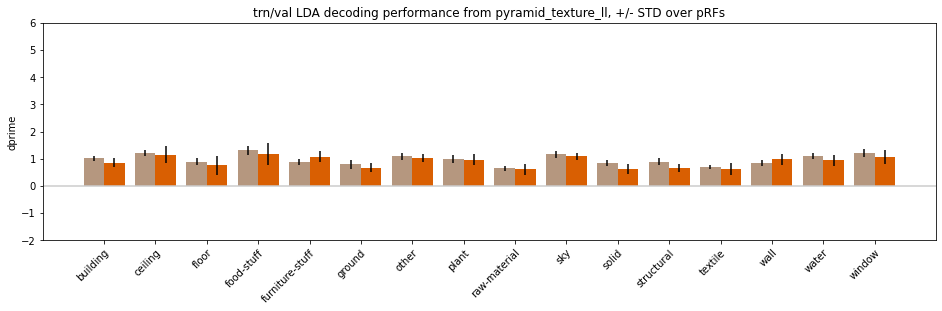

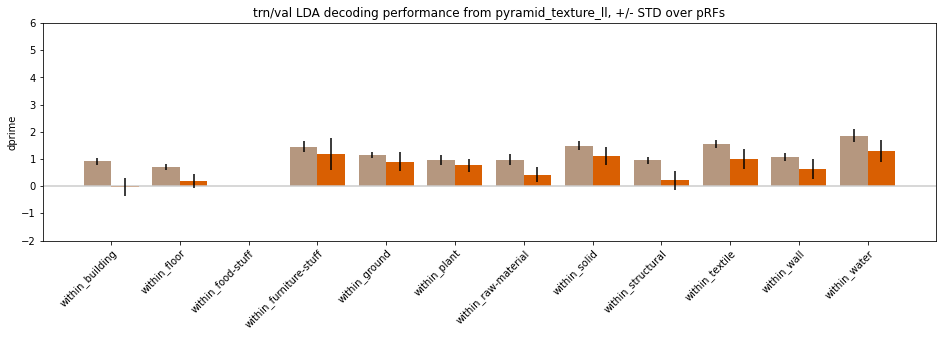

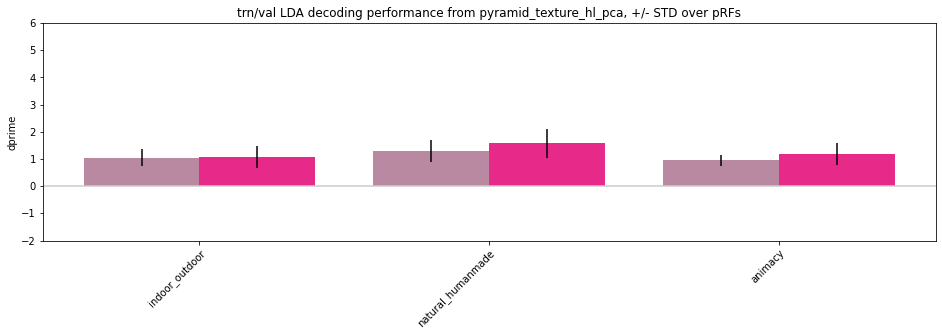

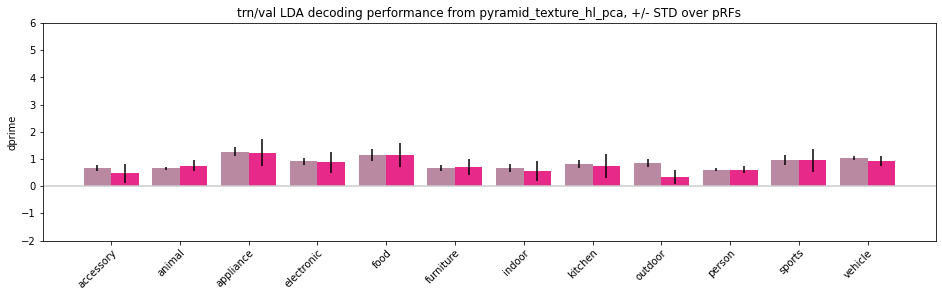

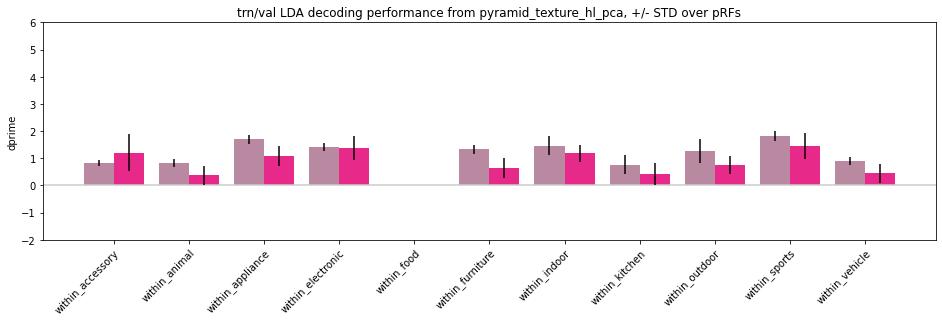

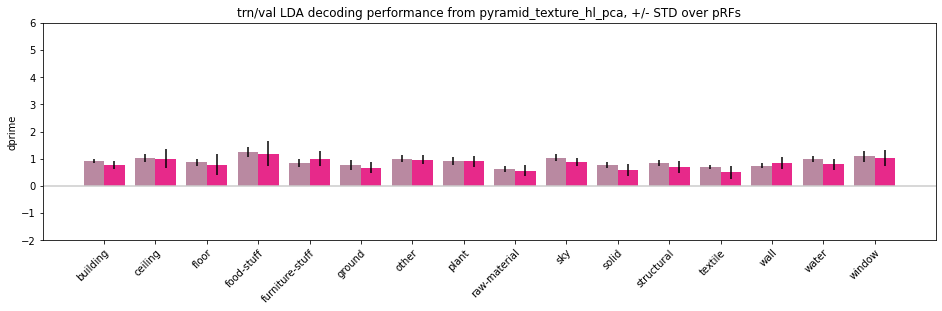

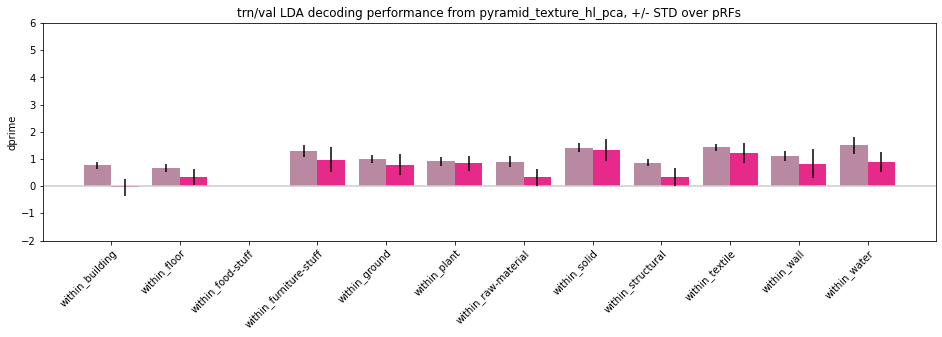

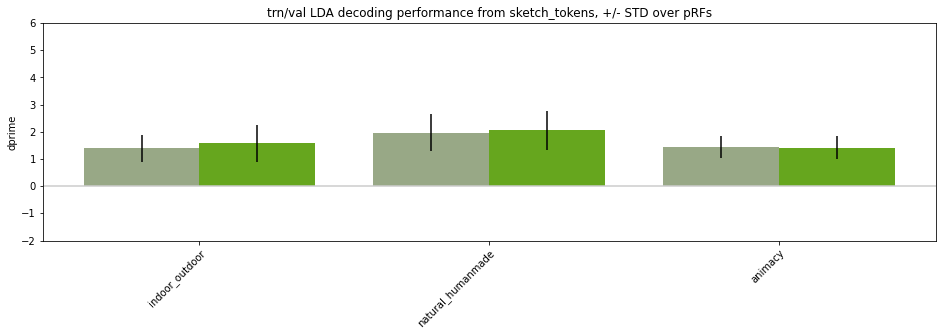

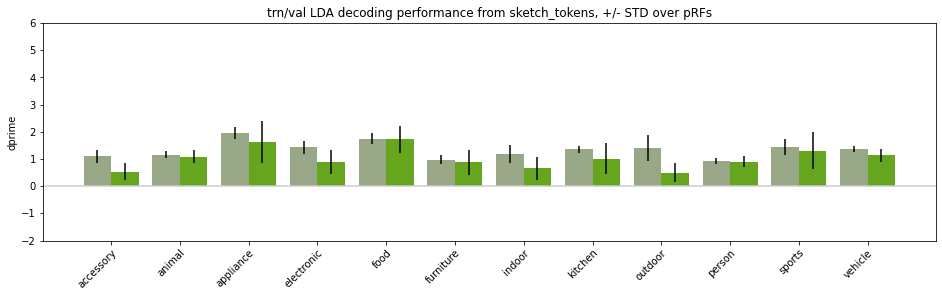

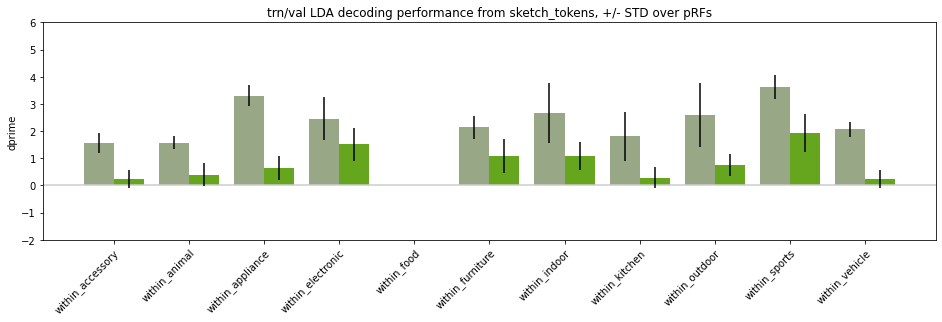

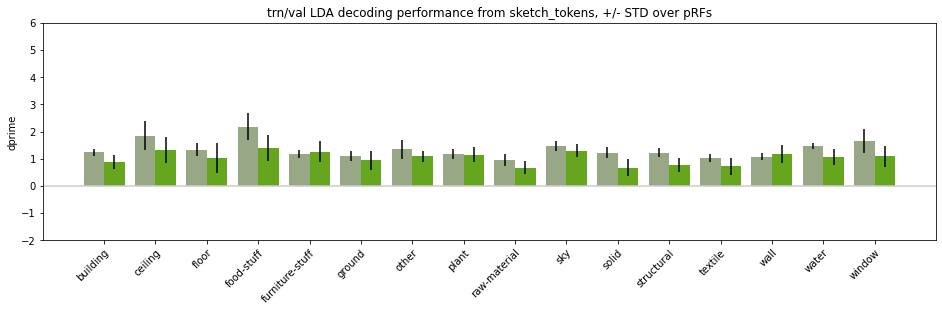

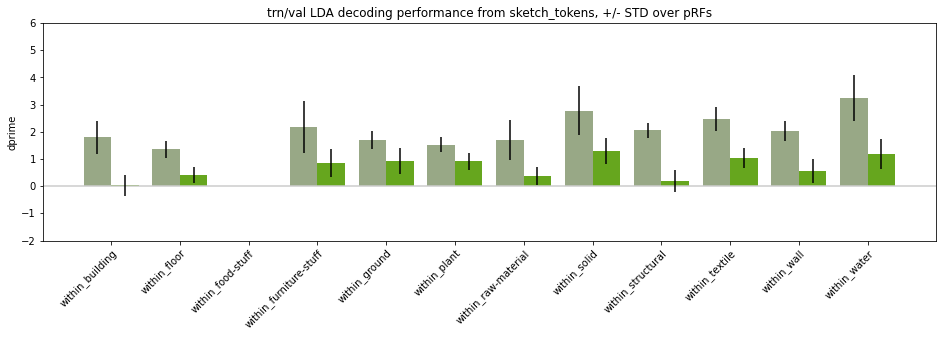

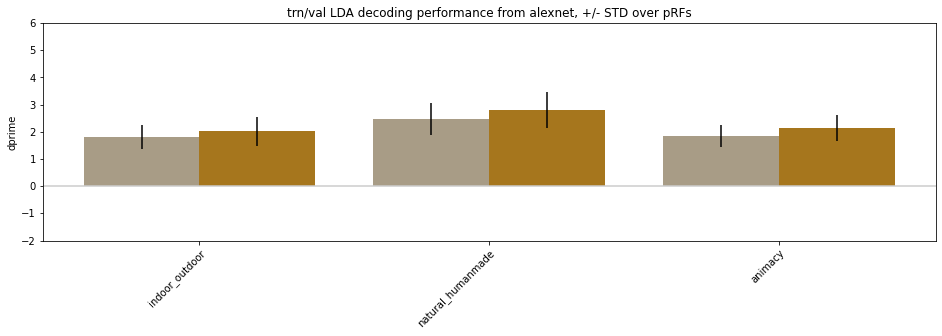

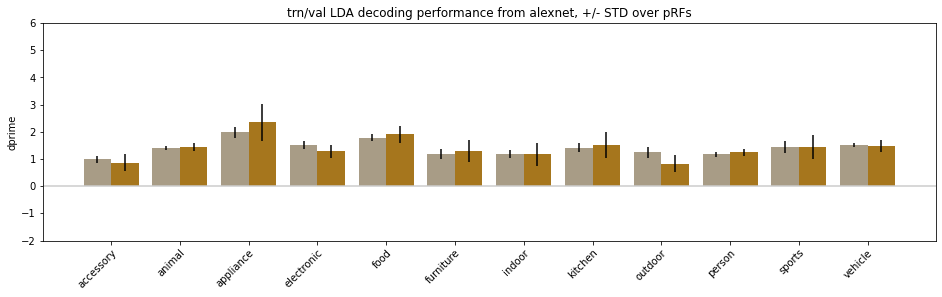

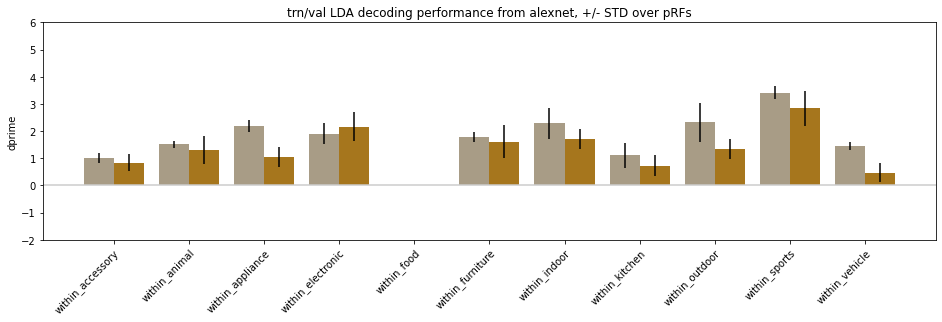

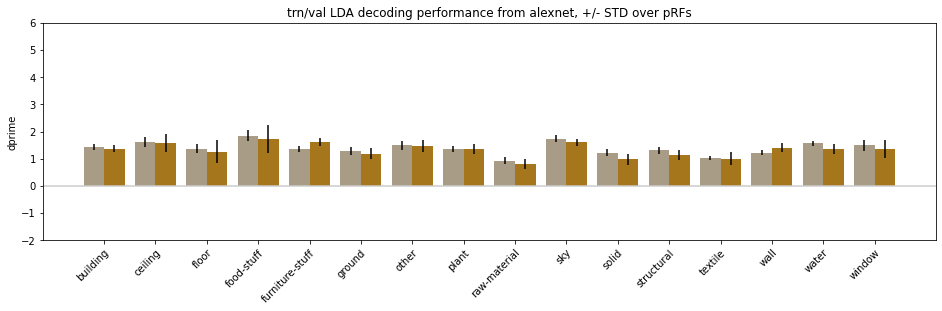

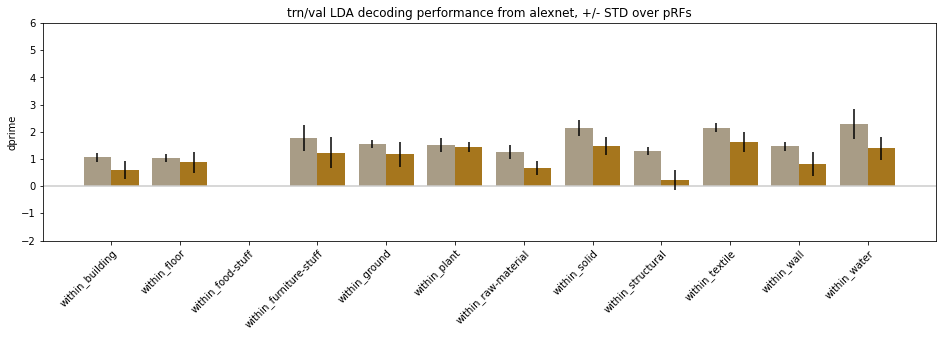

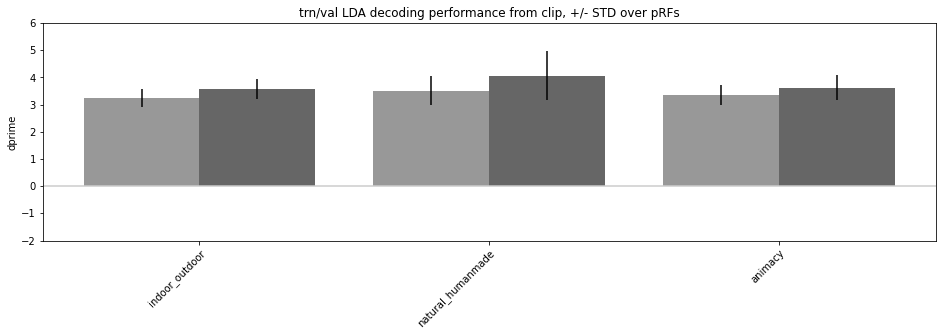

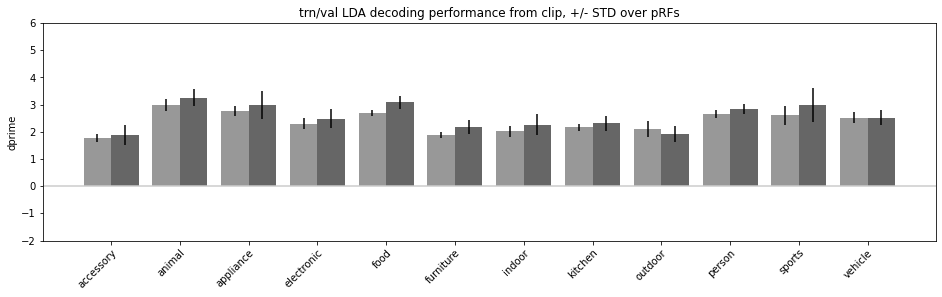

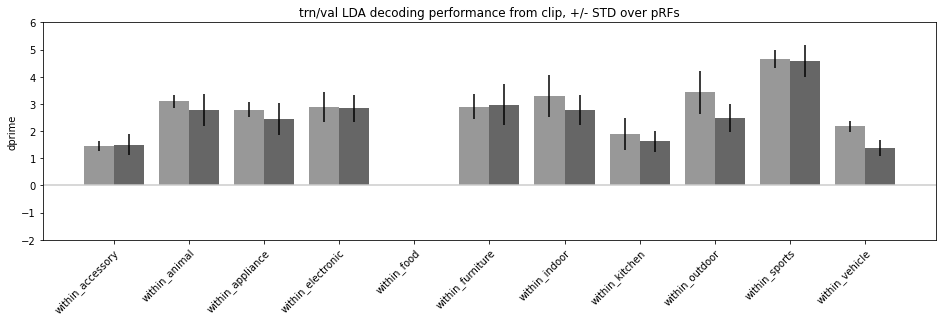

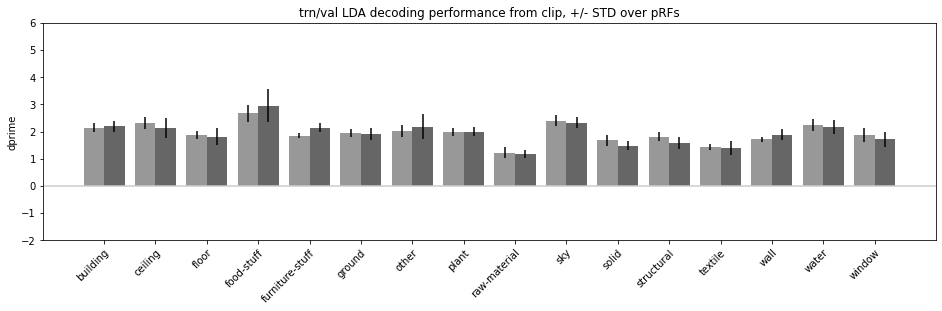

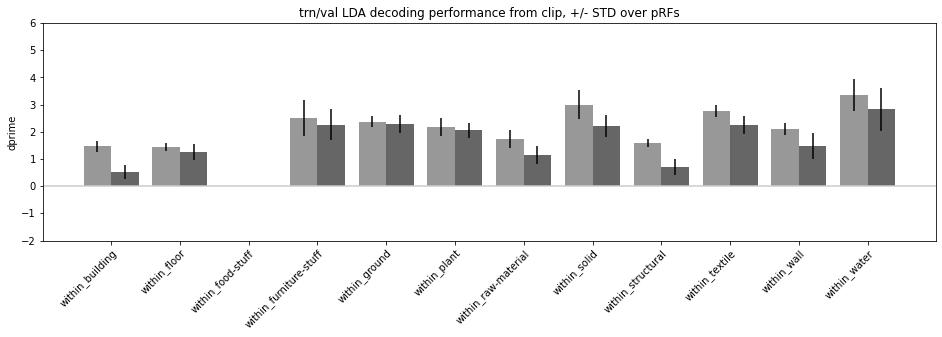

In [27]:
# plotting trn/val performance side by side, to see how much overfitting is happening

import copy
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')

# min_thresh = 10
# prfs_exclude = np.any(nval<min_thresh, axis=2) | np.any(ntrn<min_thresh, axis=2)
# n_excluded = np.sum(prfs_exclude, axis=0)
# print(n_excluded)
# inds_list = [np.arange(0,3), np.arange(3,15), np.arange(15,26), np.arange(26,42), np.arange(42,54)]

    feature_colors = cm.Dark2(np.linspace(0,1,len(feature_type_list)))
    feature_colors_2 = feature_colors*0.5

    # trn_dprime_adj = copy.deepcopy(trn_dprime)
    # val_dprime_adj = copy.deepcopy(val_dprime)
    # for dd in range(n_discrim_types):
    #     exclude = prfs_exclude[:,dd]
    #     trn_dprime_adj[:,dd,exclude] = np.nan
    #     val_dprime_adj[:,dd,exclude] = np.nan

    # for ff in [0]:
    for ff in range(len(feature_type_list)):

        for inds in inds_list:


            mean_vals = np.array([np.nanmean(trn_dprime[ff,inds,:], axis=1), \
                          np.nanmean(val_dprime[ff,inds,:], axis=1)]).T;
            std_vals = np.array([np.nanstd(trn_dprime[ff,inds,:], axis=1), \
                          np.nanstd(val_dprime[ff,inds,:], axis=1)]).T;

            title='trn/val LDA decoding performance from %s, +/- STD over pRFs'%feature_type_list[ff]
            colors = np.array([feature_colors_2[ff,:], feature_colors[ff,:]])
            plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=std_vals, \
                        colors=colors, \
                        space=0.3, \
                        xticklabels=np.array(discrim_type_list)[inds], ylabel='dprime', \
                        ylim=[-2,6], title=title, horizontal_line_pos=0,\
                        legend_labels=None, \
                        legend_overlaid=False, legend_separate=False, \
                        fig_size=(16,4))



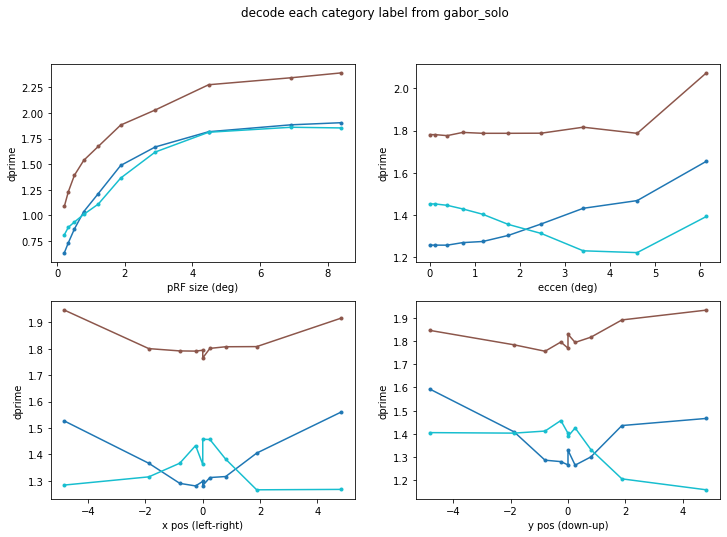

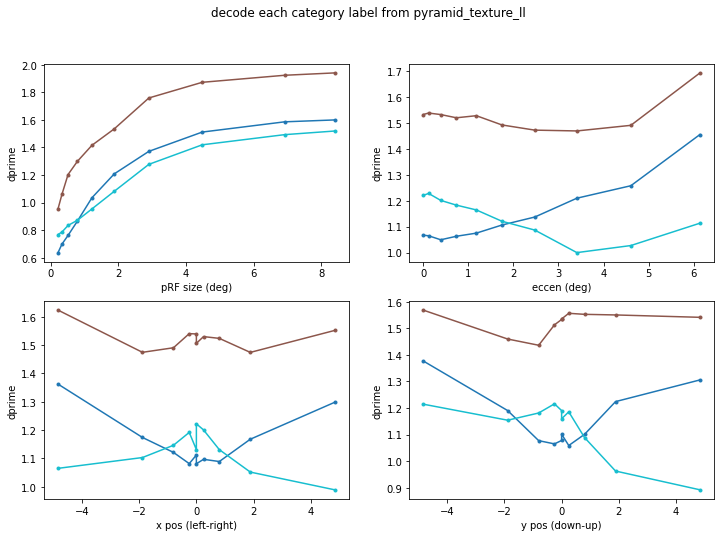

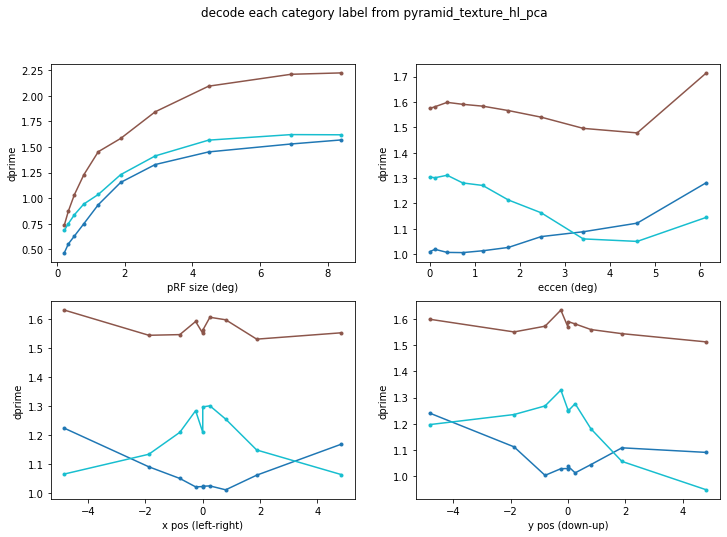

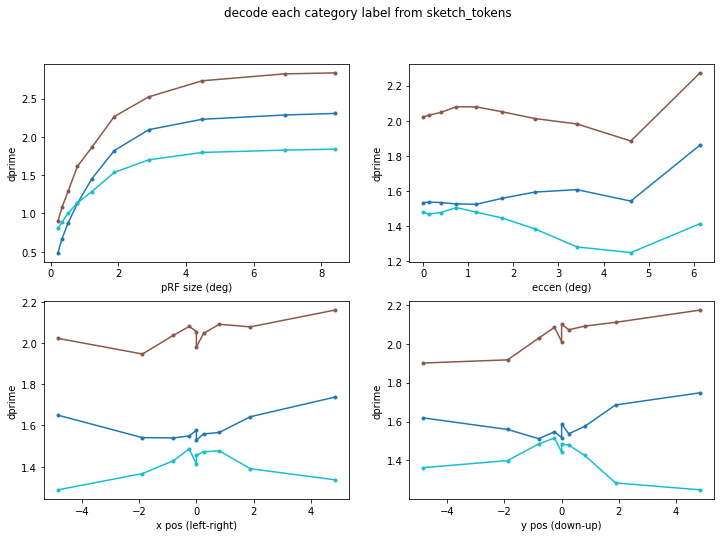

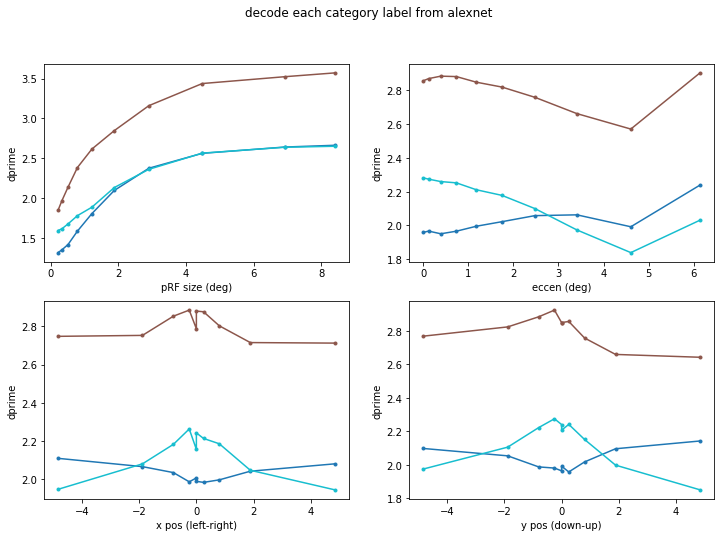

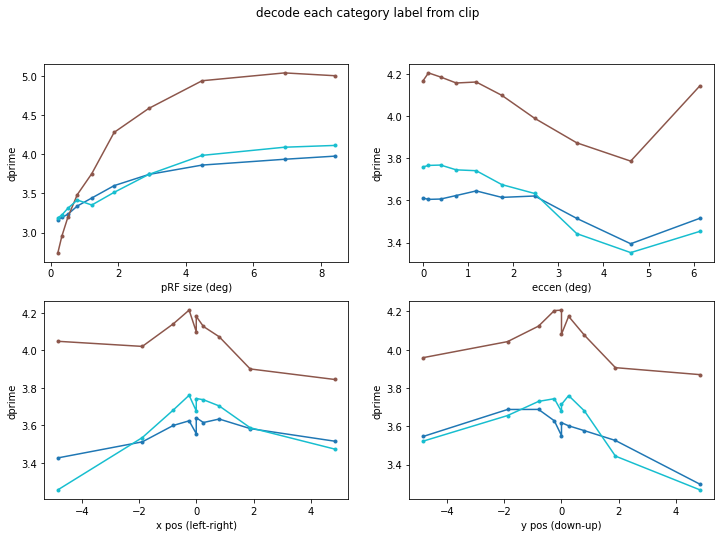

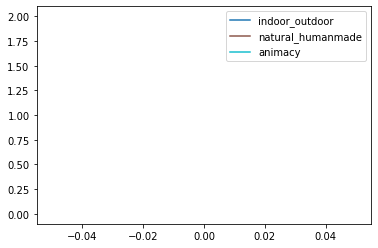

In [29]:
# Break down by pRF params, category label type, and feature type
n_bins=10
linear_bins=False

dd2plot = [0,1,2]
# dd2plot = np.arange(3,15);
discrim_colors = cm.tab10(np.linspace(0,1,len(dd2plot)))


for ff in range(len(feature_type_list)):

    feature_type = feature_type_list[ff]
    
    plt.figure(figsize=(12,8));
    
    for di, dd in enumerate(dd2plot):
        discrim_type = discrim_type_list[dd]

        dprime_vals = val_dprime[ff,dd,:]

        plt.subplot(2,2,1)
        x_vals = models[:,2]*8.4
        xbinned, ybinned = numpy_utils.bin_ydata_by_xdata(x_vals, dprime_vals, \
                                                      n_bins=n_bins, linear_bins=linear_bins)
        plt.plot(xbinned, ybinned,'.-',color=discrim_colors[di,:])
        plt.xlabel('pRF size (deg)')
        plt.ylabel('dprime')

        plt.subplot(2,2,2)
        x_vals = np.sqrt(models[:,0]**2+models[:,1]**2)*8.4
        xbinned, ybinned = numpy_utils.bin_ydata_by_xdata(x_vals, dprime_vals, \
                                                      n_bins=n_bins, linear_bins=linear_bins)
        plt.plot(xbinned, ybinned,'.-',color=discrim_colors[di,:])
        plt.xlabel('eccen (deg)')
        plt.ylabel('dprime')

        plt.subplot(2,2,3)
        x_vals = models[:,0]*8.4
        xbinned, ybinned = numpy_utils.bin_ydata_by_xdata(x_vals, dprime_vals, \
                                                      n_bins=n_bins, linear_bins=linear_bins)
        plt.plot(xbinned, ybinned,'.-',color=discrim_colors[di,:])
        plt.xlabel('x pos (left-right)')
        plt.ylabel('dprime')

        plt.subplot(2,2,4)
        x_vals = models[:,1]*8.4
        xbinned, ybinned = numpy_utils.bin_ydata_by_xdata(x_vals, dprime_vals, \
                                                      n_bins=n_bins, linear_bins=linear_bins)
        plt.plot(xbinned, ybinned,'.-',color=discrim_colors[di,:])
        plt.xlabel('y pos (down-up)')
        plt.ylabel('dprime')

        plt.suptitle('decode each category label from %s'%(feature_type))

plt.figure();
for di, dd in enumerate(dd2plot):
    discrim_type = discrim_type_list[dd]

    plt.plot(0,di,'-',color=discrim_colors[di])

plt.legend(np.array(discrim_type_list)[dd2plot])

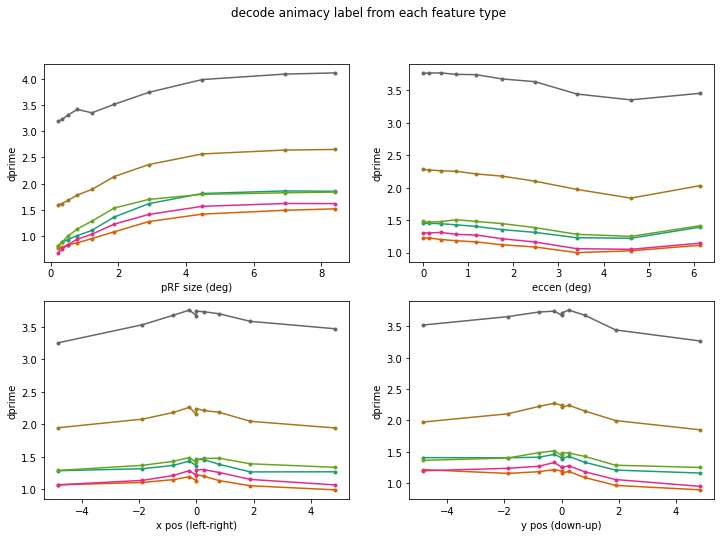

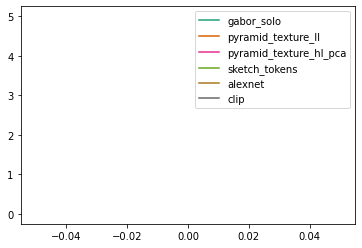

In [32]:
# Break down by pRF params, category label type, and feature type


dd=2;
discrim_type = discrim_type_list[dd]
n_bins=10
# linear_bins=True
linear_bins=False

plt.figure(figsize=(12,8));
feature_colors = cm.Dark2(np.linspace(0,1,len(feature_type_list)))

for ff, feature_type in enumerate(feature_type_list):
    
    dprime_vals = val_dprime[ff,dd,:]

    plt.subplot(2,2,1)
    x_vals = models[:,2]*8.4
    xbinned, ybinned = numpy_utils.bin_ydata_by_xdata(x_vals, dprime_vals, \
                                                  n_bins=n_bins, linear_bins=linear_bins)
    plt.plot(xbinned, ybinned,'.-',color=feature_colors[ff,:])
    plt.xlabel('pRF size (deg)')
    plt.ylabel('dprime')

    plt.subplot(2,2,2)
    x_vals = np.sqrt(models[:,0]**2+models[:,1]**2)*8.4
    xbinned, ybinned = numpy_utils.bin_ydata_by_xdata(x_vals, dprime_vals, \
                                                  n_bins=n_bins, linear_bins=linear_bins)
    plt.plot(xbinned, ybinned,'.-',color=feature_colors[ff,:])
    plt.xlabel('eccen (deg)')
    plt.ylabel('dprime')

    plt.subplot(2,2,3)
    x_vals = models[:,0]*8.4
    xbinned, ybinned = numpy_utils.bin_ydata_by_xdata(x_vals, dprime_vals, \
                                                  n_bins=n_bins, linear_bins=linear_bins)
    plt.plot(xbinned, ybinned,'.-',color=feature_colors[ff,:])
    plt.xlabel('x pos (left-right)')
    plt.ylabel('dprime')

    plt.subplot(2,2,4)
    x_vals = models[:,1]*8.4
    xbinned, ybinned = numpy_utils.bin_ydata_by_xdata(x_vals, dprime_vals, \
                                                  n_bins=n_bins, linear_bins=linear_bins)
    plt.plot(xbinned, ybinned,'.-',color=feature_colors[ff,:])
    plt.xlabel('y pos (down-up)')
    plt.ylabel('dprime')
    
    plt.suptitle('decode %s label from each feature type'%(discrim_type))
    
plt.figure();
for ff, feature_type in enumerate(feature_type_list):
    plt.plot(0,ff,'-',color=feature_colors[ff])
    
plt.legend(feature_type_list)

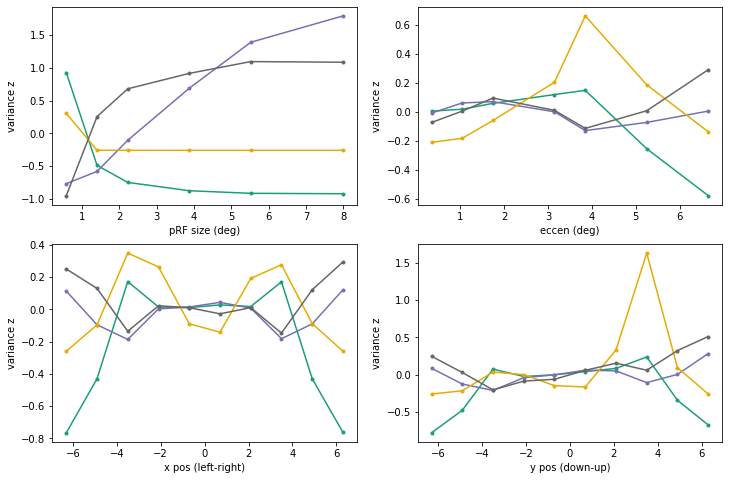

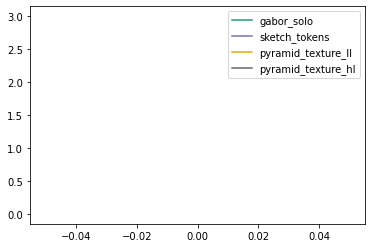

In [50]:
# For each model, plot average variance of feature channels as a function of pRF.
# Try to see if this predicts decoding of semantic labels

plt.figure(figsize=(12,8));
feature_colors = cm.Dark2(np.linspace(0,1,len(feature_type_list)))

n_bins = 10
linear_bins=True

for ff, feature_type in enumerate(feature_type_list):

    var_result = feature_var_list[ff]
    vals = np.mean(var_result, axis=0)
    vals = scipy.stats.zscore(vals)

    plt.subplot(2,2,1)
    x_vals = models[:,2]*8.4
    xbinned, ybinned = numpy_utils.bin_ydata_by_xdata(x_vals, vals, \
                                                  n_bins=n_bins, linear_bins=linear_bins)
    plt.plot(xbinned, ybinned,'.-',color=feature_colors[ff,:])
    plt.xlabel('pRF size (deg)')
    plt.ylabel('variance z')

    plt.subplot(2,2,2)
    x_vals = np.sqrt(models[:,0]**2+models[:,1]**2)*8.4
    xbinned, ybinned = numpy_utils.bin_ydata_by_xdata(x_vals, vals, \
                                                  n_bins=n_bins, linear_bins=linear_bins)
    plt.plot(xbinned, ybinned,'.-',color=feature_colors[ff,:])
    plt.xlabel('eccen (deg)')
    plt.ylabel('variance z')

    plt.subplot(2,2,3)
    x_vals = models[:,0]*8.4
    xbinned, ybinned = numpy_utils.bin_ydata_by_xdata(x_vals, vals, \
                                                  n_bins=n_bins, linear_bins=linear_bins)
    plt.plot(xbinned, ybinned,'.-',color=feature_colors[ff,:])
    plt.xlabel('x pos (left-right)')
    plt.ylabel('variance z')

    plt.subplot(2,2,4)
    x_vals = models[:,1]*8.4
    xbinned, ybinned = numpy_utils.bin_ydata_by_xdata(x_vals, vals, \
                                                  n_bins=n_bins, linear_bins=linear_bins)
    plt.plot(xbinned, ybinned,'.-',color=feature_colors[ff,:])
    plt.xlabel('y pos (down-up)')
    plt.ylabel('variance z')

plt.figure();
for ff, feature_type in enumerate(feature_type_list):
    plt.plot(0,ff,'-',color=feature_colors[ff])
    
plt.legend(feature_type_list)

In [44]:
feature_type_list

['gabor_solo', 'sketch_tokens', 'pyramid_texture_ll', 'pyramid_texture_hl']

In [3]:
# Compute n pixels for each pRF, in case this is better predictor than size. Because big/peripheral 
# pRFs lose some pixels, so size is not perfectly correlated w npixels.
prf_sums = np.zeros((n_prfs,))
for pi, prf_params in enumerate(models):
    prf = prf_utils.gauss_2d(center=[prf_params[0], prf_params[1]],\
                             sd=prf_params[2], patch_size=240)
    # Creating a mask 2 SD from the center
    # cutoff of 0.14 approximates +/-2 SDs
    prf_mask = prf/np.max(prf)>0.14
    prf_sums[pi] = np.sum(prf_mask)
    

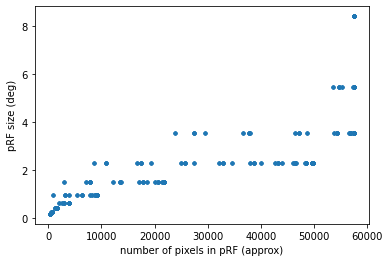

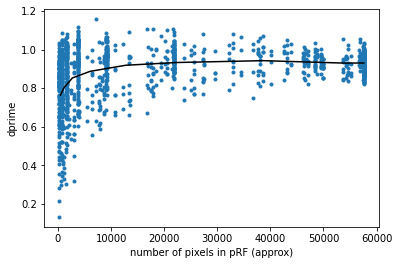

In [6]:
dd=0;ff=0;

plt.figure();
plt.plot(prf_sums,models[:,2]*8.4,'.')
plt.xlabel('number of pixels in pRF (approx)')
plt.ylabel('pRF size (deg)')

dd=0;
dprime_vals = val_dprime[ff,dd,:]
plt.figure()
x_vals = prf_sums
plt.plot(x_vals, dprime_vals,'.')
xbinned, ybinned = numpy_utils.bin_ydata_by_xdata(x_vals, dprime_vals, n_bins=10, \
                                                 linear_bins=False)
plt.plot(xbinned, ybinned, '-',color='k')
plt.xlabel('number of pixels in pRF (approx)');
plt.ylabel('dprime');

Text(0.5, 0.98, 'decode animacy from gabor_solo')

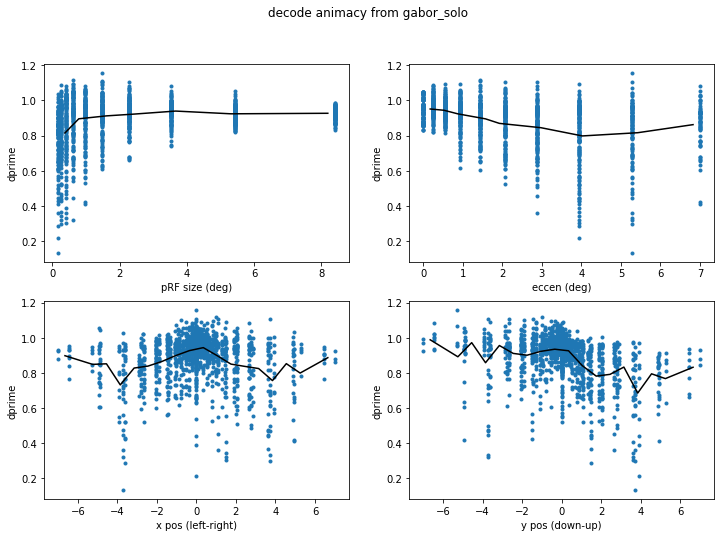

In [24]:
# Plot each individual pRF

dd=0
discrim_type = discrim_type_list[dd]
ff=0
feature_type = feature_type_list[ff]
n_bins=20
linear_bins=True

plt.figure(figsize=(12,8));
dprime_vals = val_dprime[ff,dd,:]

plt.subplot(2,2,1)
x_vals = models[:,2]*8.4
plt.plot(x_vals, dprime_vals,'.')
xbinned, ybinned = numpy_utils.bin_ydata_by_xdata(x_vals, dprime_vals, \
                                              n_bins=n_bins, linear_bins=linear_bins)
plt.plot(xbinned, ybinned,'-',color='k')
plt.xlabel('pRF size (deg)')
plt.ylabel('dprime')

plt.subplot(2,2,2)
x_vals = np.sqrt(models[:,0]**2+models[:,1]**2)*8.4
plt.plot(x_vals, dprime_vals,'.')
xbinned, ybinned = numpy_utils.bin_ydata_by_xdata(x_vals, dprime_vals, \
                                              n_bins=n_bins, linear_bins=linear_bins)
plt.plot(xbinned, ybinned,'-',color='k')
plt.xlabel('eccen (deg)')
plt.ylabel('dprime')

plt.subplot(2,2,3)
x_vals = models[:,0]*8.4
plt.plot(x_vals, dprime_vals,'.')
xbinned, ybinned = numpy_utils.bin_ydata_by_xdata(x_vals, dprime_vals, \
                                              n_bins=n_bins, linear_bins=linear_bins)
plt.plot(xbinned, ybinned,'-',color='k')
plt.xlabel('x pos (left-right)')
plt.ylabel('dprime')

plt.subplot(2,2,4)
x_vals = models[:,1]*8.4
plt.plot(x_vals, dprime_vals,'.')
xbinned, ybinned = numpy_utils.bin_ydata_by_xdata(x_vals, dprime_vals, \
                                              n_bins=n_bins, linear_bins=linear_bins)
plt.plot(xbinned, ybinned,'-',color='k')
plt.xlabel('y pos (down-up)')
plt.ylabel('dprime')

plt.suptitle('decode %s from %s'%(discrim_type, feature_type))

/home/mmhender/myenv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mmhender/myenv/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, 'decode animacy from gabor_solo features')

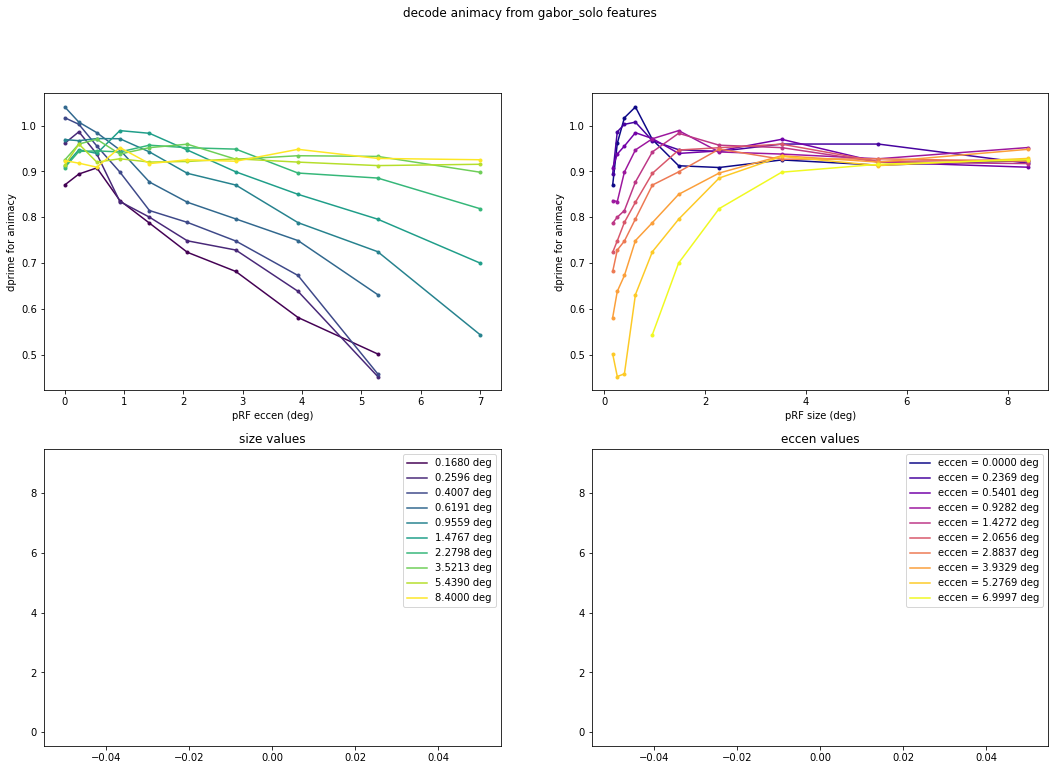

In [23]:
# Overlay sizes/eccentricities

dd=0;
ff=0;
discrim_type = discrim_type_list[dd]
feature_type = feature_type_list[ff]

prf_models = models
unique_sizes, size_inds = np.unique(np.round(prf_models[:,2],4), return_inverse=True)
eccens = np.sqrt(prf_models[:,0]**2+prf_models[:,1]**2)
unique_eccens, eccen_inds = np.unique(np.round(eccens,4), return_inverse=True)

dprime_vals = val_dprime[ff,dd,:]

dprime_size_by_eccen = np.array([[np.mean(dprime_vals[(size_inds==si) & (eccen_inds==ei)]) \
                        for ei in range(len(unique_eccens))] for si in range(len(unique_sizes))])

fig = plt.figure(figsize=(18,12));

eccen_colors = cm.plasma(np.linspace(0,1,len(unique_eccens)))
size_colors = cm.viridis(np.linspace(0,1,len(unique_sizes)))

plt.subplot(2,2,1)
for si, size in enumerate(unique_sizes):
    
    xvals = unique_eccens*8.4
    yvals = dprime_size_by_eccen[si,:]
    
    plt.plot(xvals, yvals, '.-',color=size_colors[si,:])
    plt.xlabel('pRF eccen (deg)')
    plt.ylabel('dprime for %s'%discrim_type)

plt.subplot(2,2,2)
for ei, ecc in enumerate(unique_eccens):

    xvals = unique_sizes*8.4
    yvals = dprime_size_by_eccen[:,ei]

    plt.plot(xvals, yvals, '.-', color=eccen_colors[ei,:])
    plt.xlabel('pRF size (deg)')
    plt.ylabel('dprime for %s'%discrim_type)

plt.subplot(2,2,3)
for ss in range(len(unique_sizes)):
        plt.plot(0,ss,color=size_colors[ss,:])    
plt.legend(['%.4f deg'%(unique_sizes[ss]*8.4) for ss in range(len(unique_sizes))])
plt.title('size values')

plt.subplot(2,2,4)
for ee in range(len(unique_eccens)):
    plt.plot(0,ee,color=eccen_colors[ee,:])    
plt.legend(['eccen = %.4f deg'%(unique_eccens[ee]*8.4) for ee in range(len(unique_eccens))])
plt.title('eccen values')

plt.suptitle('decode %s from %s features'%(discrim_type, feature_type))

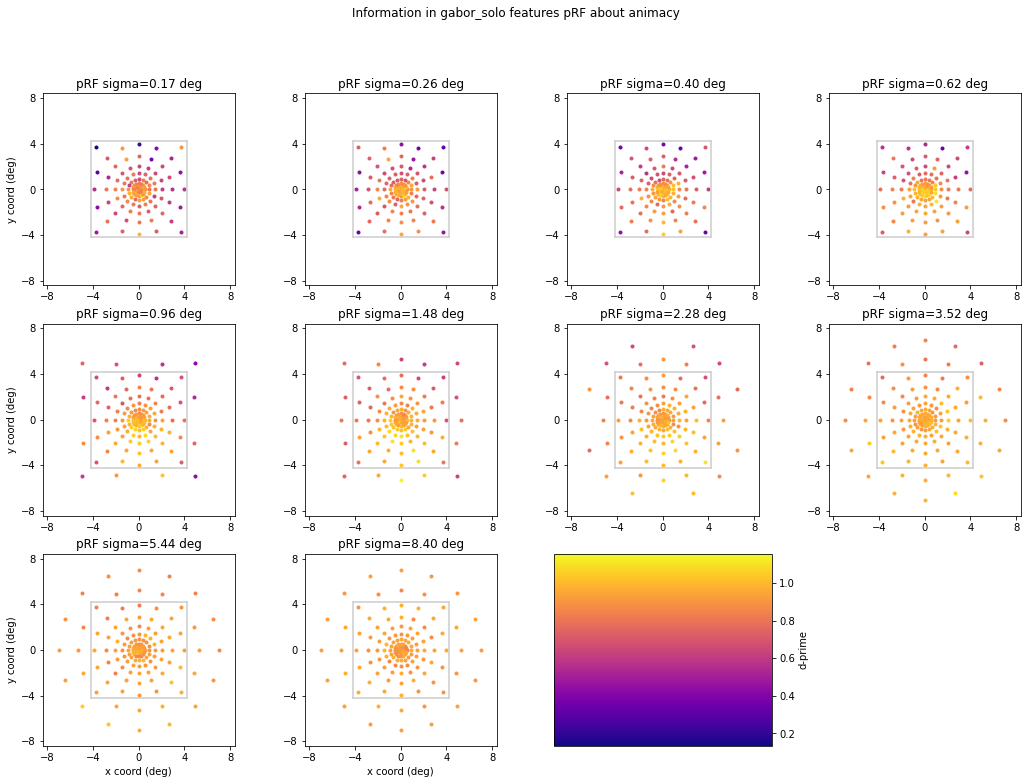

In [25]:
# Plot spatial position of pRFs, with discriminability color coded

ff = 0;
feature_type = feature_type_list[ff]
dd = 0;
discrim_type = discrim_type_list[dd]
prf_models = models

unique_sizes = np.unique(np.round(prf_models[:,2],4))

fig = plt.figure(figsize=(18,12));

n_color_steps = 100
colors = cm.plasma(np.linspace(0,1,n_color_steps))
min_dprime = 0
dprime_vals = val_dprime[ff,dd,:]

dprime_range = [np.min(dprime_vals[dprime_vals>min_dprime]), \
                np.max(dprime_vals[dprime_vals>min_dprime])]
# dprime_range = [0, 1.4]
dprime_steps = np.linspace(dprime_range[0], dprime_range[1], n_color_steps)
screen_eccen_deg = 8.4
xylims = 1.0*screen_eccen_deg

for si, size in enumerate(unique_sizes):

    inds = np.where(np.round(prf_models[:,2],4)==size)[0]

    prf_models_plot = models[inds,:]
    dprime_plot = dprime_vals[inds]
    inds2plot = np.where(dprime_plot>min_dprime)[0]
    
    plt.subplot(3,4,si+1)
    ax = plt.gca()
        
    for mm in inds2plot:
        x,y,sigma = prf_models_plot[mm,:]
        dprime = dprime_plot[mm]
        color_ind = np.argmin(np.abs(dprime_steps-dprime))
        plt.plot(x*screen_eccen_deg,y*screen_eccen_deg,'.', color=colors[color_ind,:])  
        
    plt.axis('square')
    plt.xlim([-xylims, xylims])
    plt.ylim([-xylims, xylims])
    plt.xticks(np.arange(-8,9,4))
    plt.yticks(np.arange(-8,9,4))
    
    plt.plot([screen_eccen_deg/2,screen_eccen_deg/2], [screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
    plt.plot([-screen_eccen_deg/2,-screen_eccen_deg/2], [screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
    plt.plot([-screen_eccen_deg/2,screen_eccen_deg/2], [screen_eccen_deg/2, screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
    plt.plot([-screen_eccen_deg/2,screen_eccen_deg/2], [-screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])

    if si>7:
        plt.xlabel('x coord (deg)')
    if np.mod(si,4)==0:
        plt.ylabel('y coord (deg)')

    plt.title('pRF sigma=%.2f deg'%(size*screen_eccen_deg))
    
ax = plt.subplot(3,4,si+2)
scalmap = cm.ScalarMappable(matplotlib.colors.Normalize(vmin=dprime_range[0], vmax=dprime_range[1]),\
                  cmap='plasma')
fig.colorbar(scalmap, orientation='vertical', label='d-prime',cax=ax)

plt.suptitle('Information in %s features pRF about %s'%(feature_type, discrim_type));

In [55]:
# Now load results of the encoding model fitting procedure - 
# going to look at how above results relate to pRF fits in different areas

from plotting import load_fits
subject = 1
volume_space=True
ff=0;
# fitting_type = 'sketch_tokens'
fitting_type = 'gabor_solo_ridge_12ori_8sf'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, \
                                                  n_from_end=0, root=root, verbose=True);
# load_fits.print_output_summary(out)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/gabor_solo_ridge_12ori_8sf/Dec-10-2021_1208_11/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'corr_each_feature', 'discrim_each_axis', 'feature_table_simple', 'filter_pars_simple', 'orient_filters_simple', 'feature_table_complex', 'filter_pars_complex', 'orient_filters_complex', 'feature_types_exclude', 'gabor_feature_info', 'autocorr_output_pix', 'group_all_hl_feats', 'gabor_nonlin_fn'])


In [56]:
from utils import roi_utils
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 
skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def
roi_names = ret_names+face_names+place_names+body_names
nret = len(ret_names)
nface = len(face_names)
nplace = len(place_names)
nbody = len(body_names)    
n_rois = len(ret_names) + len(face_names) + len(place_names) + len(body_names)

is_ret = np.arange(0, n_rois)<nret
is_face = (np.arange(0, n_rois)>=nret) & (np.arange(0, n_rois)<nret+nface)
is_place = (np.arange(0, n_rois)>=nret+nface) & (np.arange(0, n_rois)<nret+nface+nplace)
is_body = np.arange(0, n_rois)>=nret+nface+nplace


[-0.7058277322175082, 2.5878293226104976]
[0, 17]


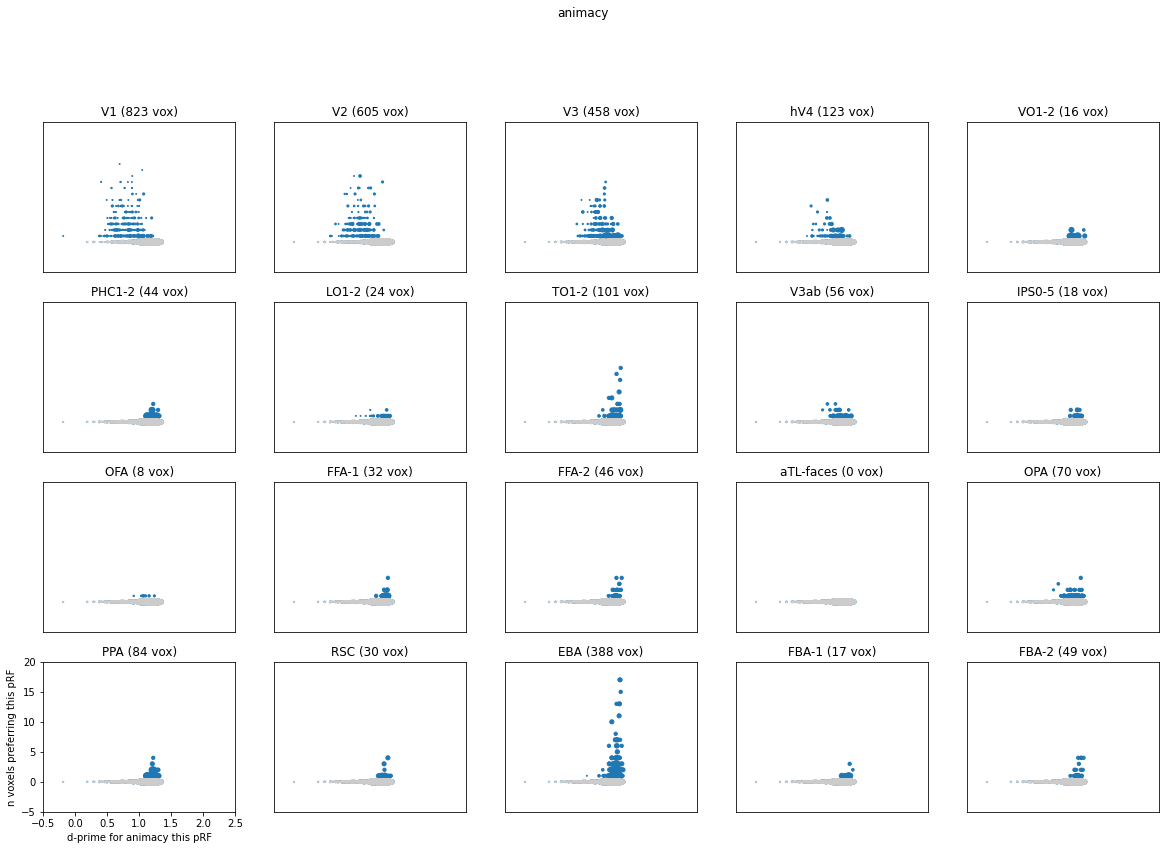

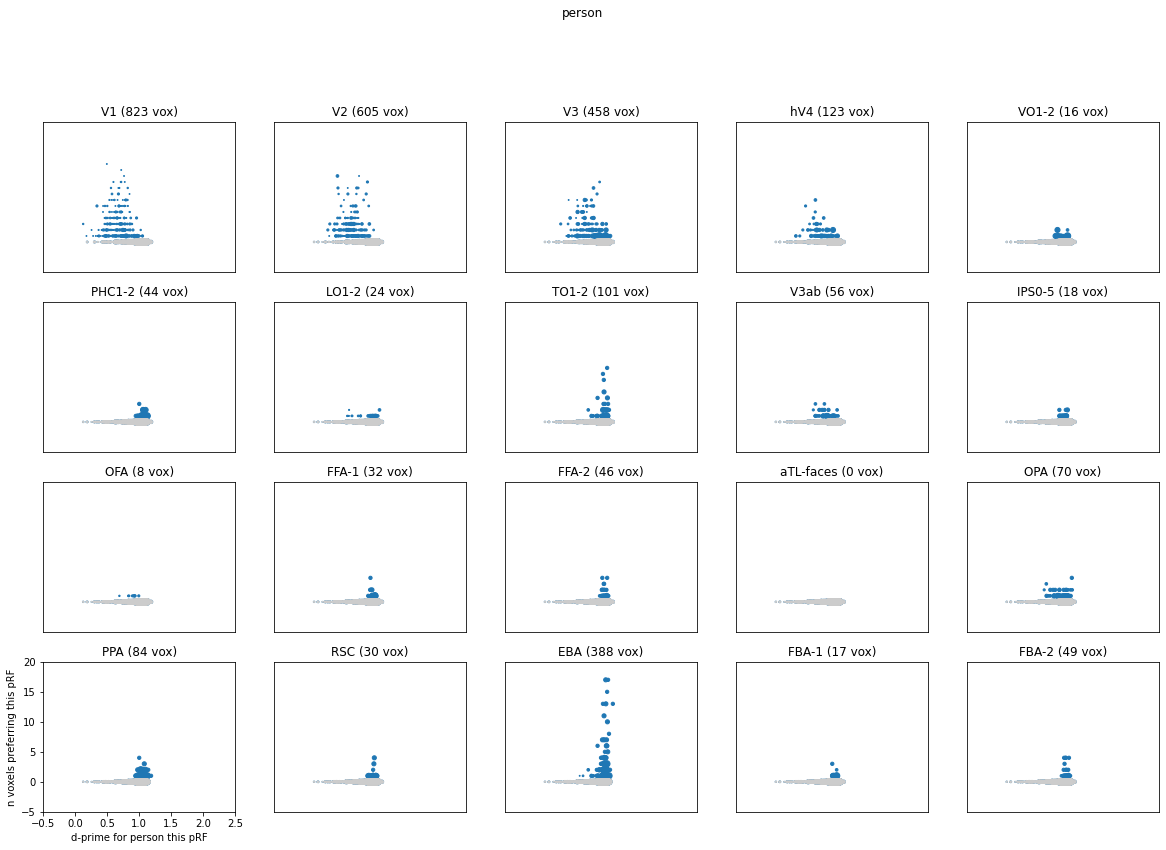

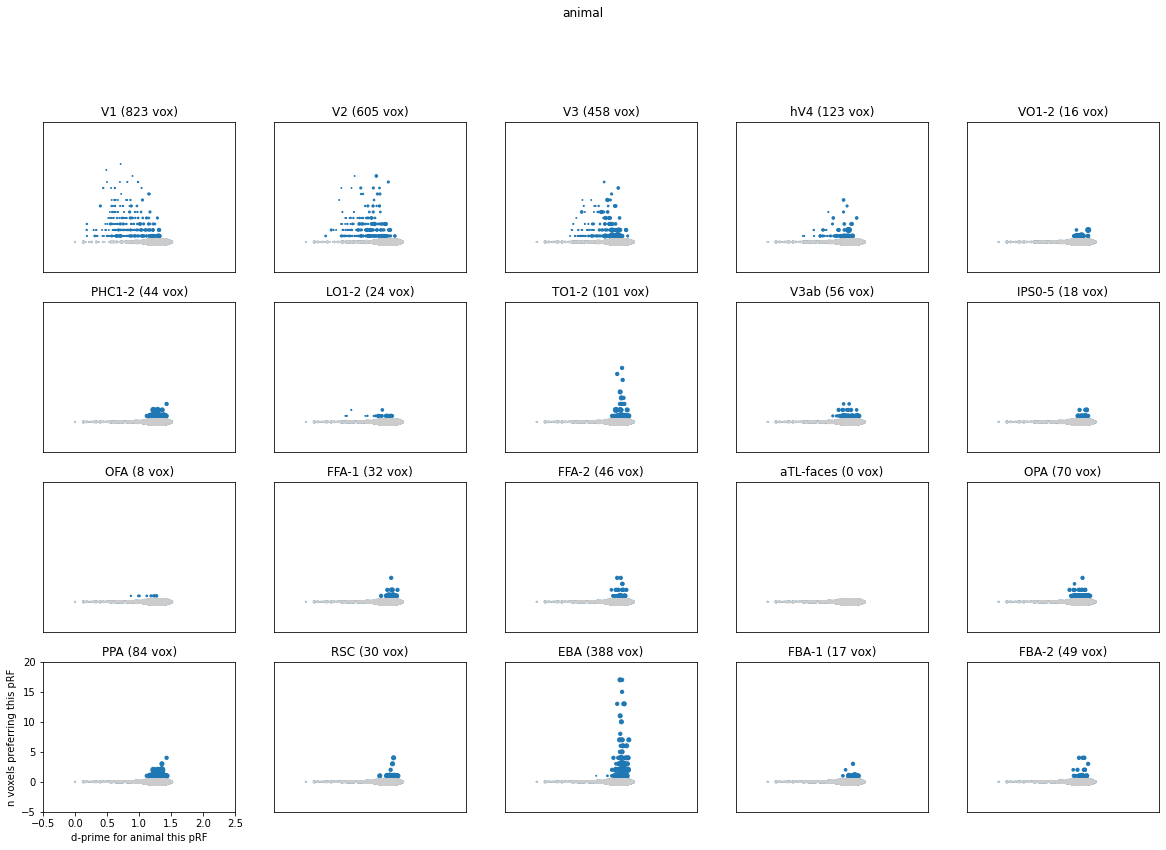

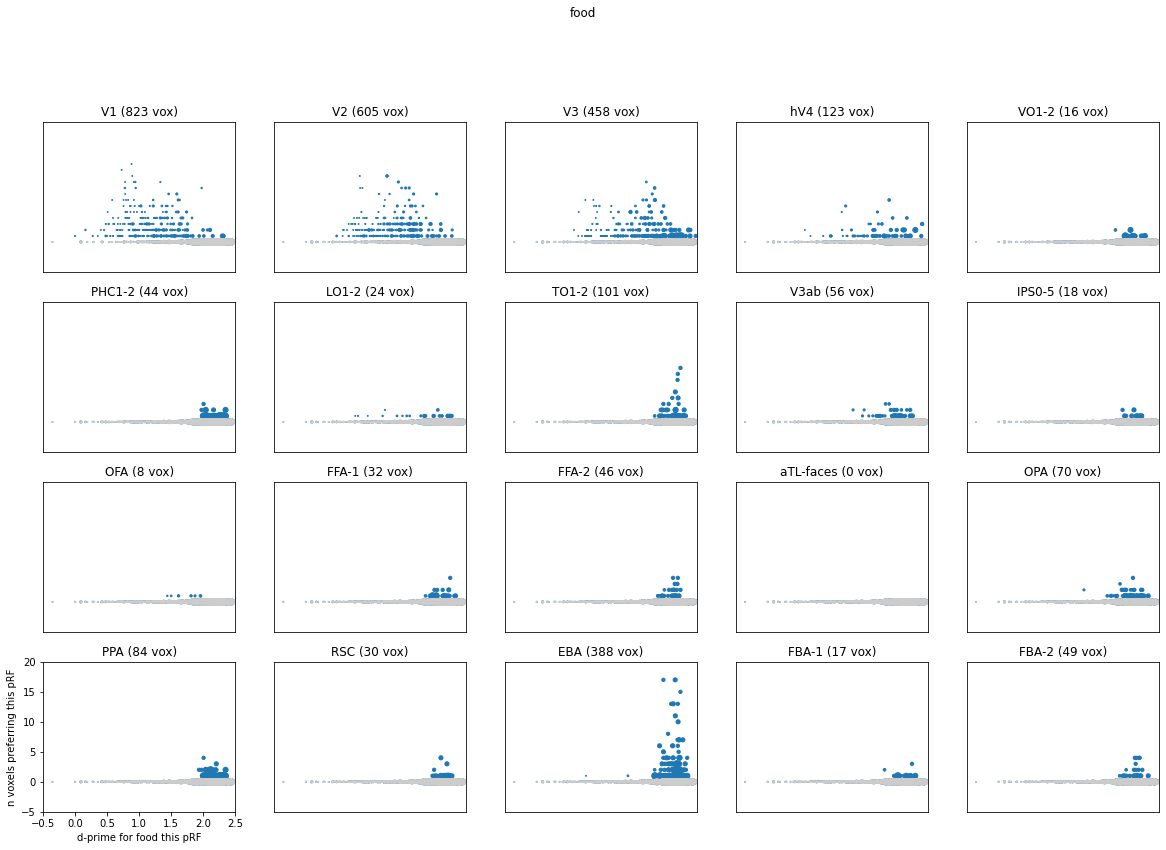

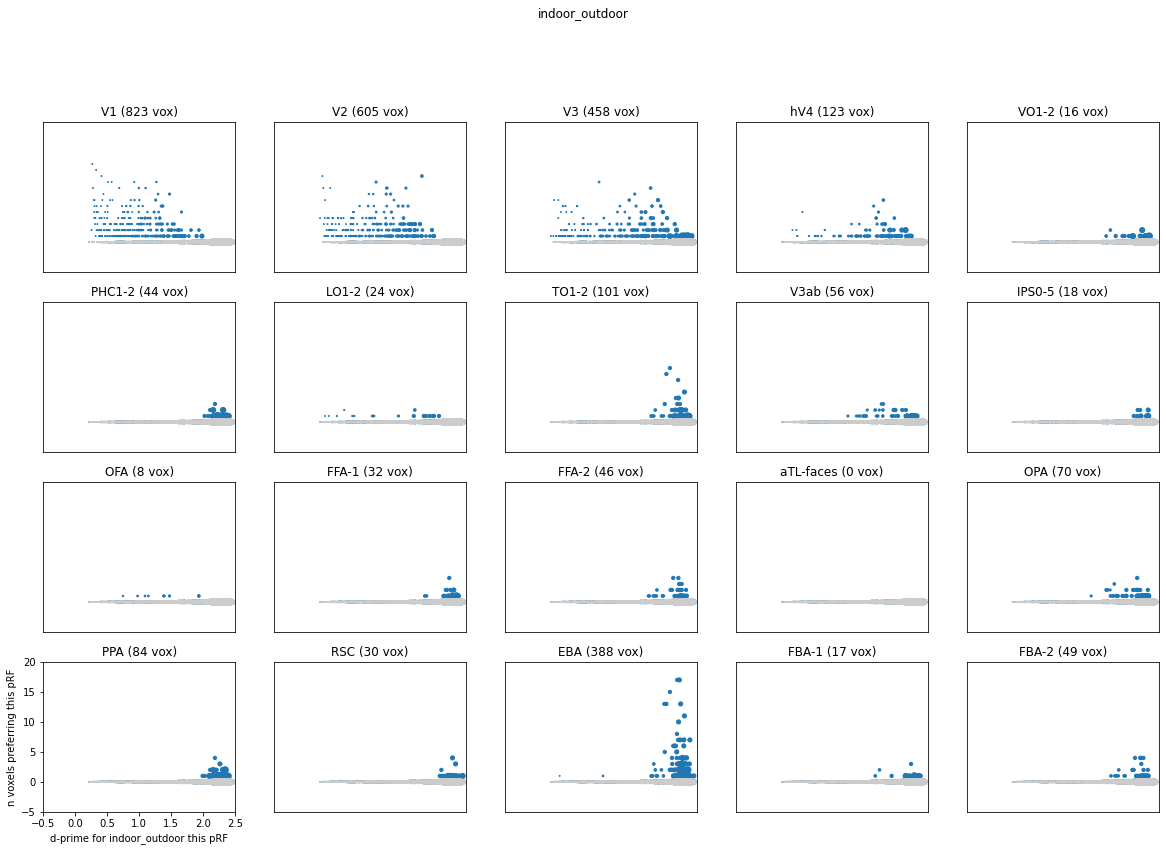

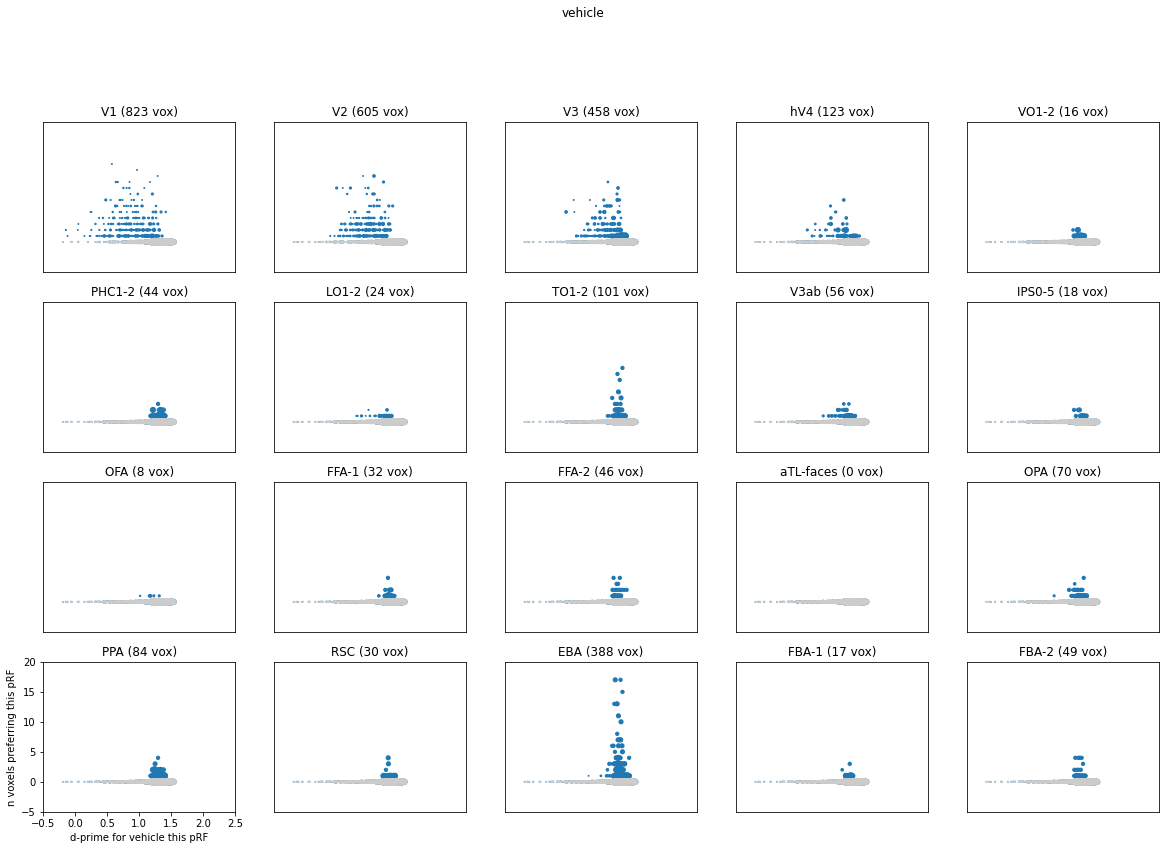

In [33]:
# For each area, plot the distribution of pRFs versus the 
# semantic information content of the pRFs

dorder = [0,2,3,4,1,5]

running_xmin=100; running_ymin=100;
running_xmax=-100; running_ymax=-100;

    
for dd in dorder:
    
    discrim_type = discrim_type_list[dd]

    prf_models = models

    dprime_vals = val_dprime[ff,dd,:]
    
    r2_cutoff = 0.10
    val_r2 = out['val_r2'][:,0]
    abv_thresh = val_r2>r2_cutoff

    plt.figure(figsize=(20,16))
    npx = int(np.ceil(np.sqrt(n_rois)))
    npy = int(np.ceil(n_rois/npx))

   
    pi=0
    for rr in range(n_rois):

        if rr not in skip_inds:
            if is_ret[rr]:
                inds_this_roi = retlabs==rr
                rname = ret_names[rr]
            elif is_face[rr]:
                inds_this_roi = facelabs==(rr-nret)
                rname = face_names[rr-nret]
            elif is_place[rr]:
                inds_this_roi = placelabs==(rr-nret-nface)
                rname = place_names[rr-nret-nface]
            elif is_body[rr]:
                inds_this_roi = bodylabs==(rr-nret-nface-nplace)
                rname = body_names[rr-nret-nface-nplace]

            inds_this_roi = inds_this_roi & abv_thresh
            pi+=1
            plt.subplot(npx,npy,pi)

            xvals = dprime_vals
            neach = np.array([np.sum(out['best_params'][5][inds_this_roi,0]==mm) for mm in range(n_prfs)])
            yvals = neach

            running_xmin = np.min([running_xmin, np.min(xvals)])
            running_ymin = np.min([running_ymin, np.min(yvals)])
            running_xmax = np.max([running_xmax, np.max(xvals)])
            running_ymax = np.max([running_ymax, np.max(yvals)])

            size_vals = prf_models[:,2]*40
            plt.scatter(dprime_vals, neach,s=size_vals)
            plt.scatter(dprime_vals[neach==0], neach[neach==0],s=size_vals[neach==0],color=[0.8, 0.8, 0.8])
            
            if pi==n_rois-8: 
                plt.xlabel('d-prime for %s this pRF'%(discrim_type))
                plt.ylabel('n voxels preferring this pRF')
            else:
                plt.xticks([])
                plt.yticks([])

            plt.title('%s (%d vox)'%(rname, np.sum(inds_this_roi)))
            plt.xlim([-0.5, 2.5])
            plt.ylim([-5,20])
            
    plt.suptitle(discrim_type)

print([running_xmin, running_xmax])
print([running_ymin, running_ymax])


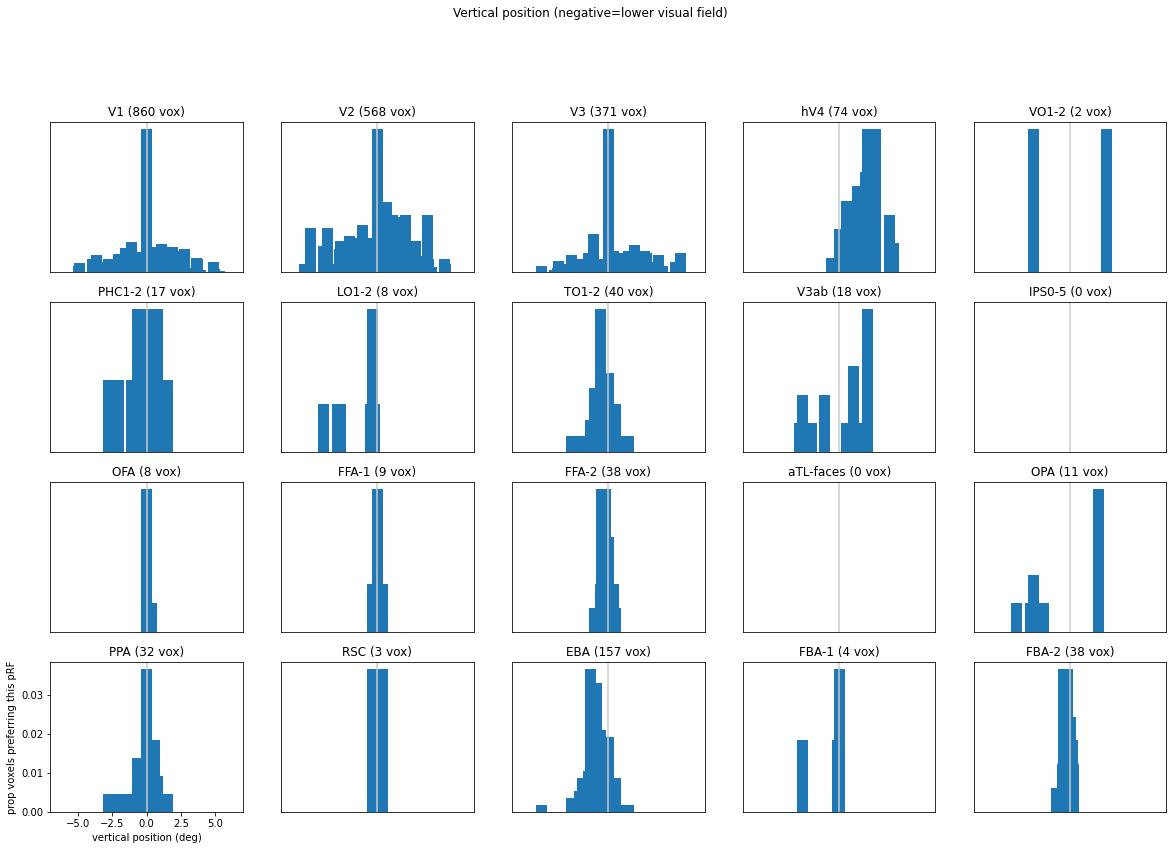

In [66]:
# Plot histograms of vertical position preferences each ROI

prf_models = models

r2_cutoff = 0.10
val_r2 = out['val_r2'][:,0]
abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,16))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

unique_pos = np.round(np.unique(prf_models[:,1]),4)*8.4

pi=0
for rr in range(n_rois):

    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
            rname = ret_names[rr]
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
            rname = face_names[rr-nret]
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
            rname = place_names[rr-nret-nface]
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
            rname = body_names[rr-nret-nface-nplace]

        inds_this_roi = inds_this_roi & abv_thresh
        pi+=1
        plt.subplot(npx,npy,pi)

        if np.sum(inds_this_roi)>0:
            vals = np.round(out['best_params'][0][inds_this_roi,0,1],4)*8.4
            counts = [np.sum(vals==un) for un in unique_pos]
            plt.bar(unique_pos, counts/np.sum(counts))
        
        if pi==n_rois-8: 
            plt.xlabel('vertical position (deg)')
            plt.ylabel('prop voxels preferring this pRF')
        else:
            plt.xticks([])
            plt.yticks([])
            
        plt.xlim([-7, 7])
#         plt.ylim([0, 0.4])

        plt.axvline(0, color=[0.8,0.8,0.8])
        
        plt.title('%s (%d vox)'%(rname, np.sum(inds_this_roi)))
        
        
    plt.suptitle('Vertical position (negative=lower visual field)')

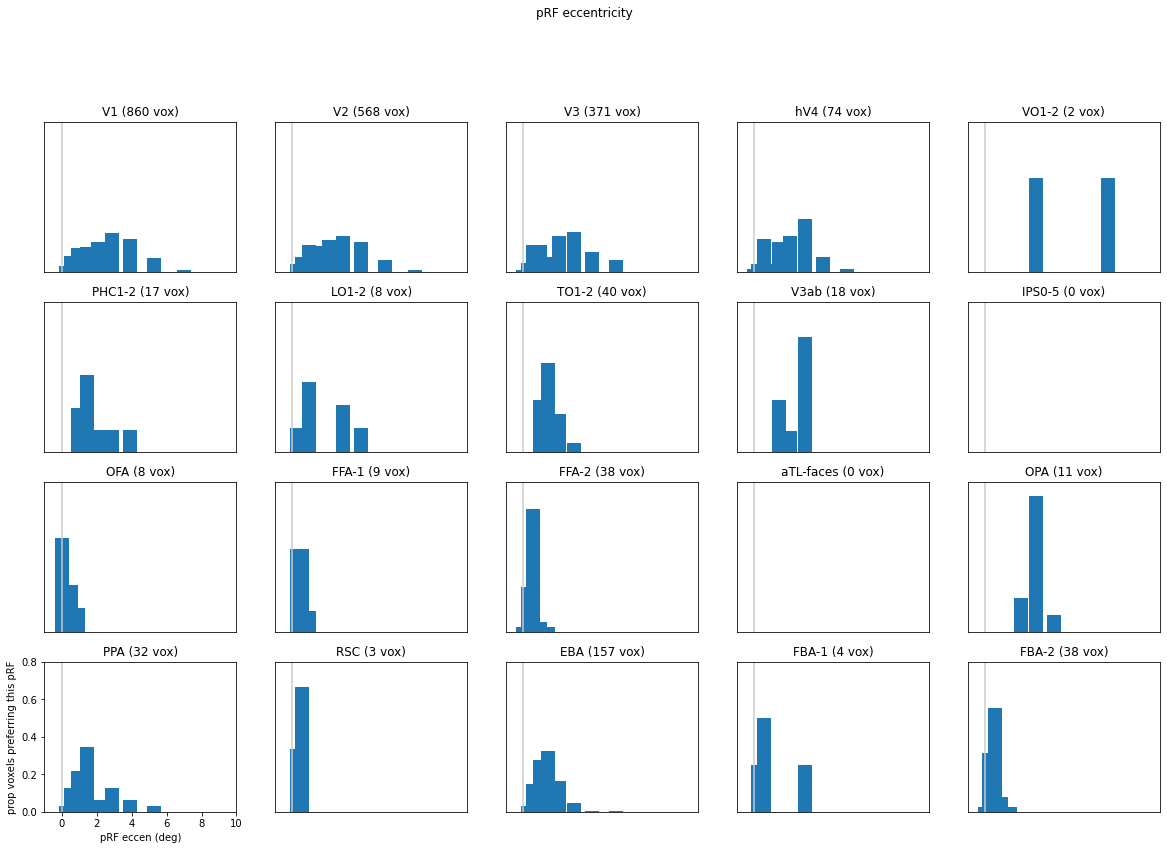

In [79]:
# plot histograms of eccen preferences each roi

prf_models = models

r2_cutoff = 0.10
val_r2 = out['val_r2'][:,0]
abv_thresh = val_r2>r2_cutoff

plt.figure(figsize=(20,16))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

eccen_vals = np.sqrt(prf_models[:,0]**2+prf_models[:,1]**2)
unique_eccen = np.unique(np.round(eccen_vals,4))*8.4

pi=0
for rr in range(n_rois):

    if rr not in skip_inds:
        if is_ret[rr]:
            inds_this_roi = retlabs==rr
            rname = ret_names[rr]
        elif is_face[rr]:
            inds_this_roi = facelabs==(rr-nret)
            rname = face_names[rr-nret]
        elif is_place[rr]:
            inds_this_roi = placelabs==(rr-nret-nface)
            rname = place_names[rr-nret-nface]
        elif is_body[rr]:
            inds_this_roi = bodylabs==(rr-nret-nface-nplace)
            rname = body_names[rr-nret-nface-nplace]

        inds_this_roi = inds_this_roi & abv_thresh
        pi+=1
        plt.subplot(npx,npy,pi)

        if np.sum(inds_this_roi)>0:
            vals = np.round(np.sqrt(out['best_params'][0][inds_this_roi,0,0]**2 + \
                                        out['best_params'][0][inds_this_roi,0,1]**2),4)*8.4
            counts = [np.sum(vals==un) for un in unique_vals]
            plt.bar(unique_vals, counts/np.sum(counts))
        
        if pi==n_rois-8: 
            plt.xlabel('pRF eccen (deg)')
            plt.ylabel('prop voxels preferring this pRF')
        else:
            plt.xticks([])
            plt.yticks([])
            
        plt.xlim([-1,10])
        plt.ylim([0, 0.8])

        plt.axvline(0, color=[0.8,0.8,0.8])
        
        plt.title('%s (%d vox)'%(rname, np.sum(inds_this_roi)))
        
        
    plt.suptitle('pRF eccentricity')

Text(0.5, 0.98, 'Number of voxels all areas with this pRF')

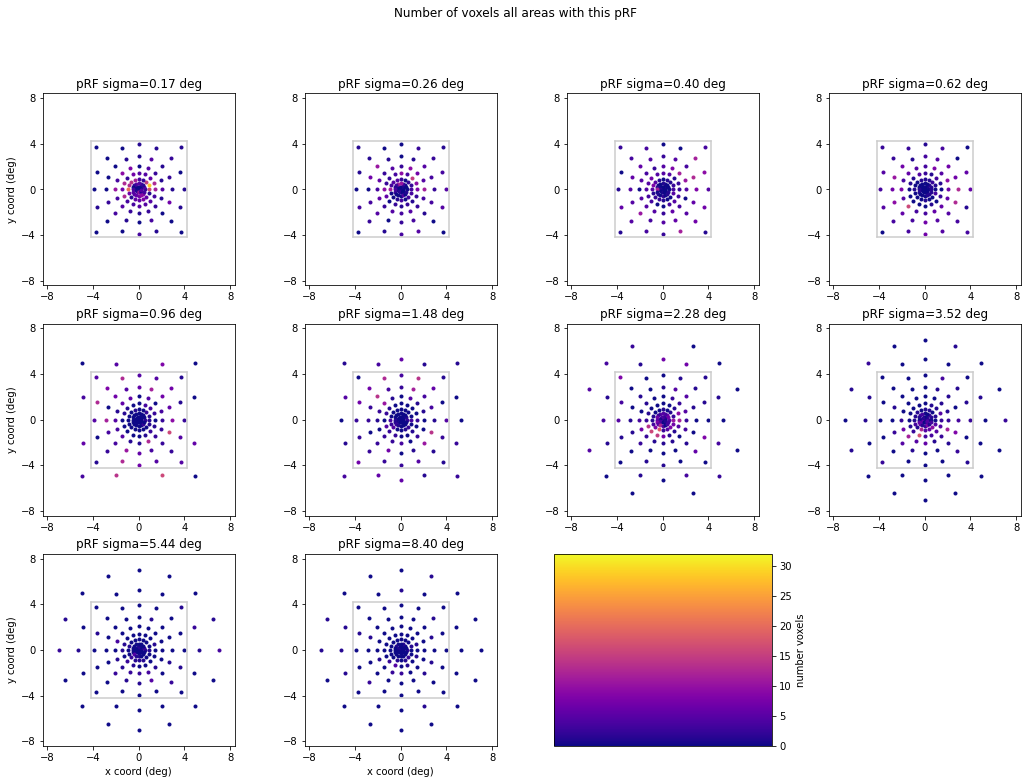

In [34]:
# Plot the spatial distribution voxels' preferred pRFs

r2_cutoff = 0.10
val_r2 = out['val_r2'][:,0]
abv_thresh = val_r2>r2_cutoff

prf_models = models
neach = np.array([np.sum(out['best_params'][5][abv_thresh,0]==mm) for mm in range(n_prfs)])
unique_sizes = np.unique(np.round(prf_models[:,2],4))

fig = plt.figure(figsize=(18,12));

n_color_steps = np.max(neach)
colors = cm.plasma(np.linspace(0,1,n_color_steps))
# vals_range = [np.min(neach), \
#                 np.max(neach)]
vals_range = [0,32]
vals_steps = np.linspace(vals_range[0], vals_range[1], n_color_steps)
screen_eccen_deg = 8.4
xylims = 1.0*screen_eccen_deg

for si, size in enumerate(unique_sizes):

    inds = np.where(np.round(prf_models[:,2],4)==size)[0]

    prf_models_plot = models[inds,:]
    vals_plot = neach[inds]
#     dprime_plot = np.array(lda_result['val_dprime'])[inds]
    plt.subplot(3,4,si+1)
    ax = plt.gca()
        
    for mm in range(len(prf_models_plot)):
        x,y,sigma = prf_models_plot[mm,:]
#         dprime = dprime_plot[mm]
        val = vals_plot[mm]
        color_ind = np.argmin(np.abs(vals_steps-val))
#         print(colors[color_ind,:])
        plt.plot(x*screen_eccen_deg,y*screen_eccen_deg,'.', color=colors[color_ind,:])  
        
    plt.axis('square')
    plt.xlim([-xylims, xylims])
    plt.ylim([-xylims, xylims])
    plt.xticks(np.arange(-8,9,4))
    plt.yticks(np.arange(-8,9,4))
    
    plt.plot([screen_eccen_deg/2,screen_eccen_deg/2], [screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
    plt.plot([-screen_eccen_deg/2,-screen_eccen_deg/2], [screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
    plt.plot([-screen_eccen_deg/2,screen_eccen_deg/2], [screen_eccen_deg/2, screen_eccen_deg/2],color=[0.8, 0.8, 0.8])
    plt.plot([-screen_eccen_deg/2,screen_eccen_deg/2], [-screen_eccen_deg/2, -screen_eccen_deg/2],color=[0.8, 0.8, 0.8])

    if si>7:
        plt.xlabel('x coord (deg)')
    if np.mod(si,4)==0:
        plt.ylabel('y coord (deg)')

    plt.title('pRF sigma=%.2f deg'%(size*screen_eccen_deg))
    
ax = plt.subplot(3,4,si+2)
scalmap = cm.ScalarMappable(matplotlib.colors.Normalize(vmin=vals_range[0], vmax=vals_range[1]),\
                  cmap='plasma')
fig.colorbar(scalmap, orientation='vertical', label='number voxels',cax=ax)

plt.suptitle('Number of voxels all areas with this pRF')

Text(0.5, 0.98, 'variance of pyramid_texture_ll features')

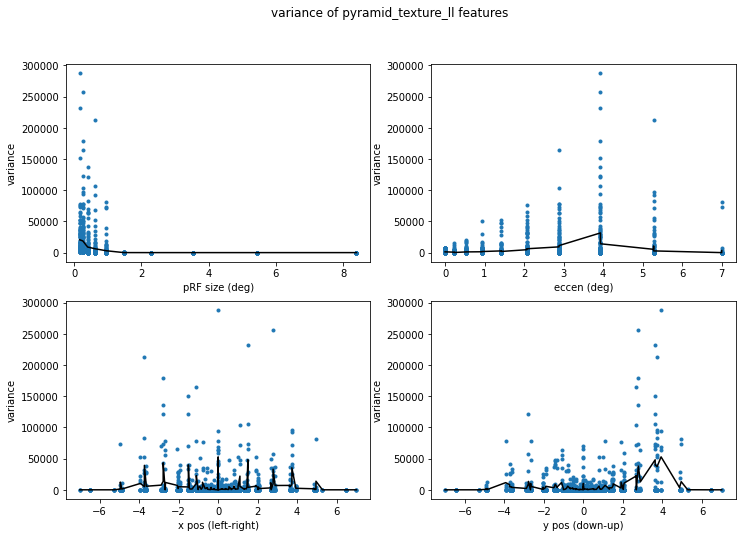

In [53]:
# for a single model, plot variance of individual pRFs, averaged over feature channels

ff=2;
var_result = feature_var_list[ff]

plt.figure(figsize=(12,8));
vals = np.mean(var_result, axis=0)

plt.subplot(2,2,1)
x_vals = models[:,2]*8.4
plt.plot(x_vals, vals,'.')
plt.plot(np.unique(x_vals), [np.mean(vals[x_vals==xv]) for xv in np.unique(x_vals)],'-',color='k')
plt.xlabel('pRF size (deg)')
plt.ylabel('variance')

plt.subplot(2,2,2)
x_vals = np.sqrt(models[:,0]**2+models[:,1]**2)*8.4
plt.plot(x_vals, vals,'.')
plt.plot(np.unique(x_vals), [np.mean(vals[x_vals==xv]) for xv in np.unique(x_vals)],'-',color='k')
plt.xlabel('eccen (deg)')
plt.ylabel('variance')

plt.subplot(2,2,3)
x_vals = models[:,0]*8.4
plt.plot(x_vals, vals,'.')
plt.plot(np.unique(x_vals), [np.mean(vals[x_vals==xv]) for xv in np.unique(x_vals)],'-',color='k')
plt.xlabel('x pos (left-right)')
plt.ylabel('variance')

plt.subplot(2,2,4)
x_vals = models[:,1]*8.4
plt.plot(x_vals, vals,'.')
plt.plot(np.unique(x_vals), [np.mean(vals[x_vals==xv]) for xv in np.unique(x_vals)],'-',color='k')
plt.xlabel('y pos (down-up)')
plt.ylabel('variance')

plt.suptitle('variance of %s features'%feature_type_list[ff])

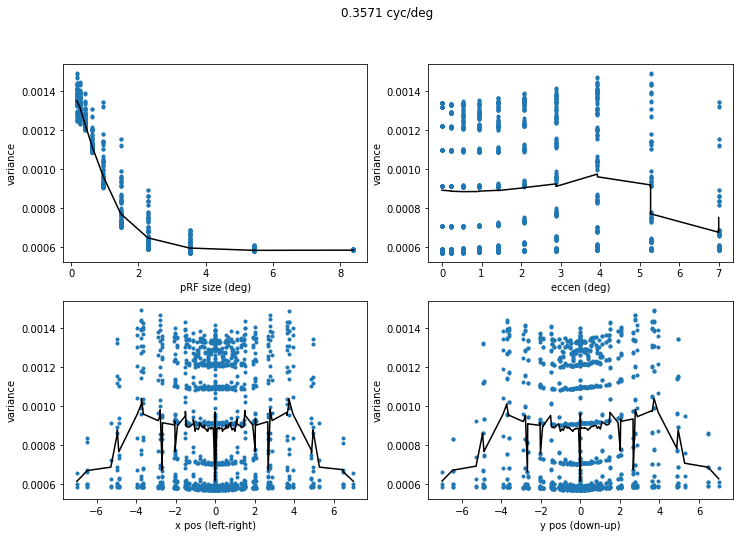

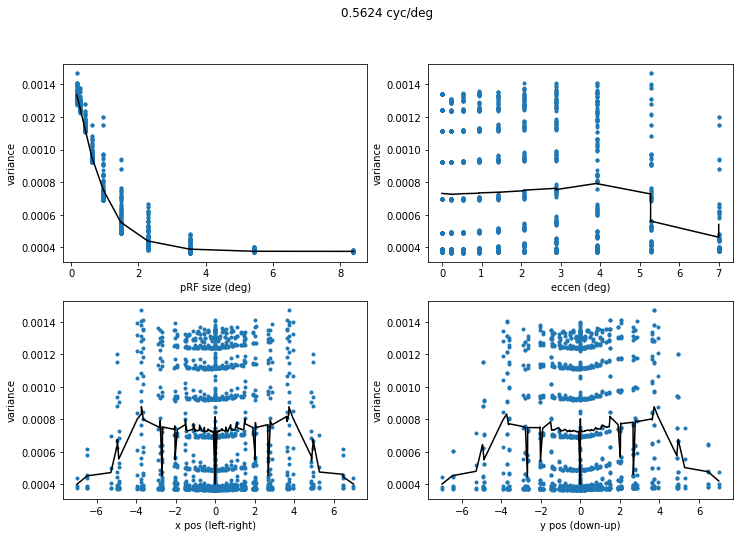

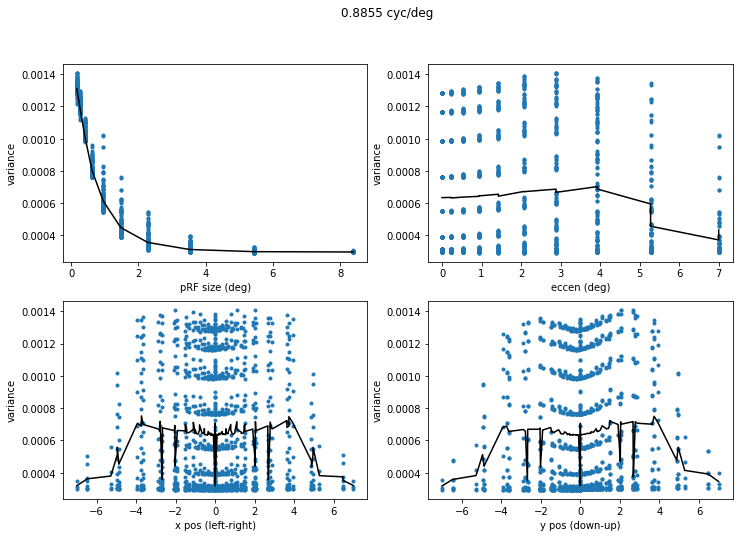

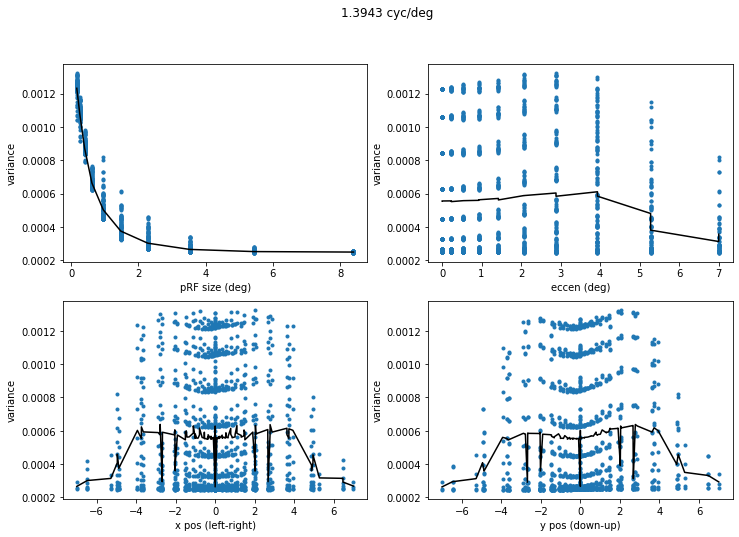

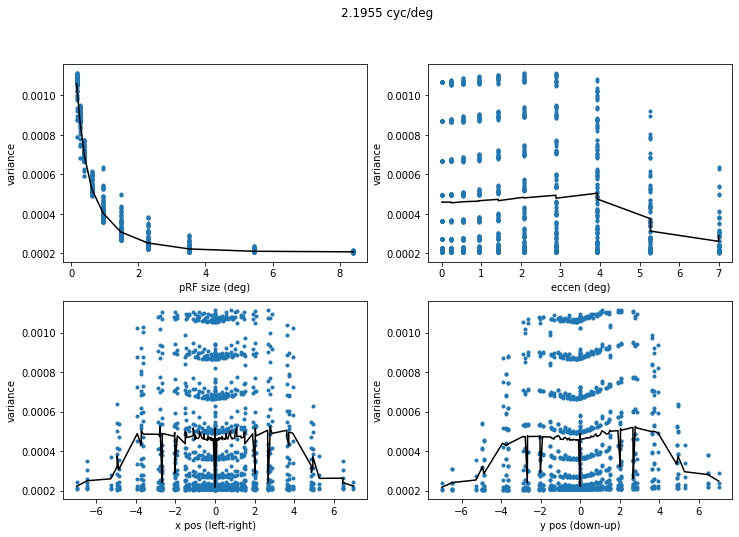

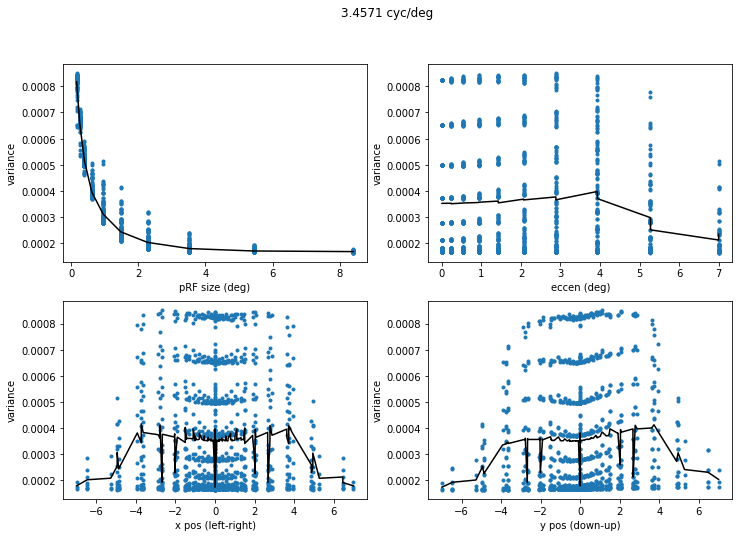

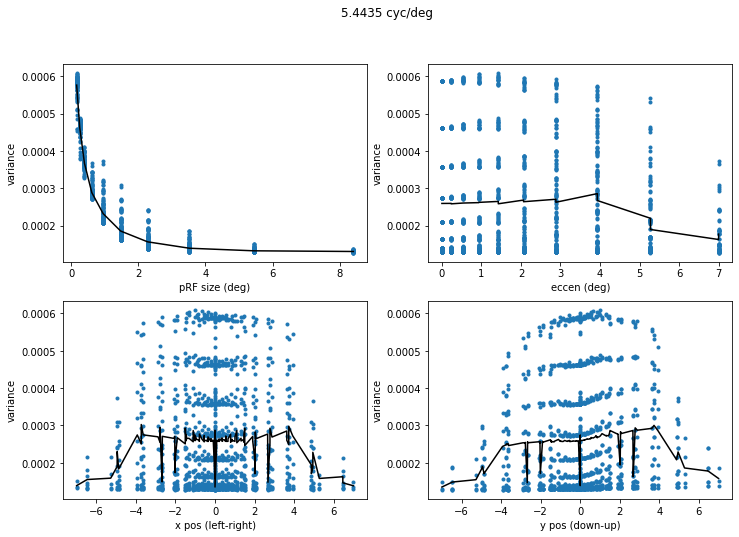

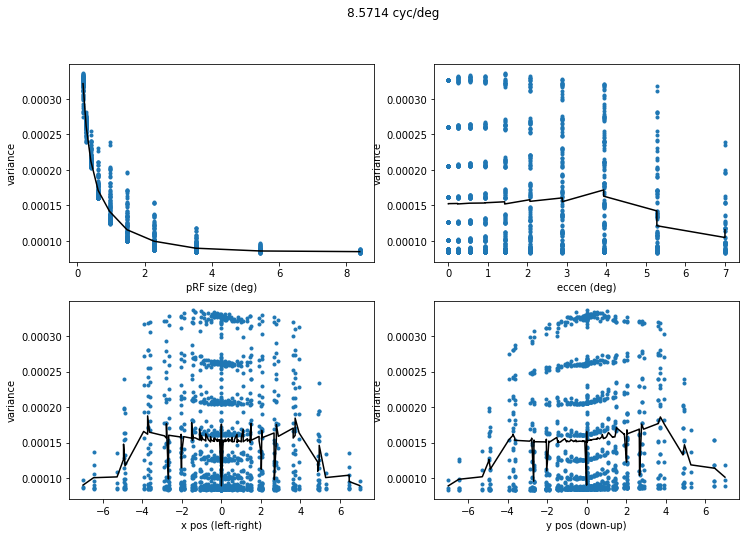

In [58]:
# for gabor model, break this down by spatial frequency
assert(ff==0)
var_result = feature_var_list[ff]

cyc_per_stim = np.array(out['feature_table_complex']['SF: cycles per stim'])
# cyc_per_stim = np.unique(cyc_per_stim)
screen_eccen_deg=8.4
cyc_per_deg = cyc_per_stim/screen_eccen_deg
sf_vals_cyc_per_deg, sf_inds = np.unique(cyc_per_deg, return_inverse=True)

orients_deg = np.array(out['feature_table_complex']['Orientation: degrees'])
orient_vals_deg, orient_inds = np.unique(orients_deg, return_inverse=True)

for sf, sf_val in enumerate(sf_vals_cyc_per_deg):

    plt.figure(figsize=(12,8));
    inds = sf_inds==sf
    vals = np.mean(var_result[inds,:], axis=0)

    plt.subplot(2,2,1)
    x_vals = models[:,2]*8.4
    plt.plot(x_vals, vals,'.')
    plt.plot(np.unique(x_vals), [np.mean(vals[x_vals==xv]) for xv in np.unique(x_vals)],'-',color='k')
    plt.xlabel('pRF size (deg)')
    plt.ylabel('variance')

    plt.subplot(2,2,2)
    x_vals = np.sqrt(models[:,0]**2+models[:,1]**2)*8.4
    plt.plot(x_vals, vals,'.')
    plt.plot(np.unique(x_vals), [np.mean(vals[x_vals==xv]) for xv in np.unique(x_vals)],'-',color='k')
    plt.xlabel('eccen (deg)')
    plt.ylabel('variance')

    plt.subplot(2,2,3)
    x_vals = models[:,0]*8.4
    plt.plot(x_vals, vals,'.')
    plt.plot(np.unique(x_vals), [np.mean(vals[x_vals==xv]) for xv in np.unique(x_vals)],'-',color='k')
    plt.xlabel('x pos (left-right)')
    plt.ylabel('variance')

    plt.subplot(2,2,4)
    x_vals = models[:,1]*8.4
    plt.plot(x_vals, vals,'.')
    plt.plot(np.unique(x_vals), [np.mean(vals[x_vals==xv]) for xv in np.unique(x_vals)],'-',color='k')
    plt.xlabel('y pos (down-up)')
    plt.ylabel('variance')

    plt.suptitle('%.4f cyc/deg'%sf_val)

In [37]:
# Compute n pixels for each pRF, in case this is better predictor than size. Because big/peripheral 
# pRFs lose some pixels, so size is not perfectly correlated w npixels.
prf_sums = np.zeros((n_prfs,))
for pi, prf_params in enumerate(models):
    prf = prf_utils.gauss_2d(center=[prf_params[0], prf_params[1]],\
                             sd=prf_params[2], patch_size=240)
#     prf = prf/np.max(prf)
    # Creating a mask 2 SD from the center
    # cutoff of 0.14 approximates +/-2 SDs
    prf_mask = prf/np.max(prf)>0.14
    prf_sums[pi] = np.sum(prf_mask)
    
 

Text(0, 0.5, 'dprime')

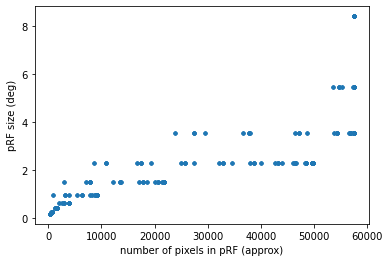

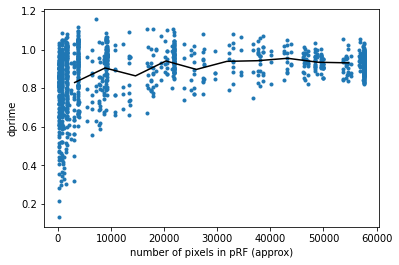

In [41]:
   
plt.figure();
plt.plot(prf_sums,models[:,2]*8.4,'.')
plt.xlabel('number of pixels in pRF (approx)')
plt.ylabel('pRF size (deg)')

dd=0;ff=0;
dprime_vals = val_dprime[ff,dd,:]

n_bins=10;
linear_bins=True

plt.figure()
x_vals = prf_sums
plt.plot(x_vals, dprime_vals,'.')
xbinned, ybinned = numpy_utils.bin_ydata_by_xdata(x_vals, dprime_vals, \
                                                  n_bins=n_bins, linear_bins=linear_bins)
plt.plot(xbinned, ybinned,'-',color='k')
plt.xlabel('number of pixels in pRF (approx)')
plt.ylabel('dprime')